# Analysis of COVID-19 Data from The New York Times

*Author: Mark Bauer*  
*Date: March 28, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.0.2
matplotlib.pyplot 3.0.2
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

covid_19_state_data = pd.read_csv(url)

In [4]:
covid_19_state_data.head(10)

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0
5  2020-01-25  California     6      1       0
6  2020-01-25    Illinois    17      1       0
7  2020-01-25  Washington    53      1       0
8  2020-01-26     Arizona     4      1       0
9  2020-01-26  California     6      2       0

In [5]:
table = covid_19_state_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="state", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | state         | cases   | deaths   |
|---:|:-----------|:--------------|:--------|:---------|
|  0 | 2020-04-22 | New York      | 257,246 | 15,302   |
|  1 | 2020-04-22 | New Jersey    | 95,865  | 5,063    |
|  2 | 2020-04-22 | Massachusetts | 42,944  | 2,182    |
|  3 | 2020-04-22 | California    | 37,573  | 1,425    |
|  4 | 2020-04-22 | Pennsylvania  | 36,763  | 1,720    |
|  5 | 2020-04-22 | Illinois      | 35,108  | 1,577    |
|  6 | 2020-04-22 | Michigan      | 33,929  | 2,812    |
|  7 | 2020-04-22 | Florida       | 28,301  | 926      |
|  8 | 2020-04-22 | Louisiana     | 25,258  | 1,473    |
|  9 | 2020-04-22 | Connecticut   | 22,469  | 1,544    |


In [6]:
covid_19_state_data.shape

(2833, 5)

In [7]:
print('New York Times COVID-19 data as of', covid_19_state_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-04-22


In [8]:
current_date = covid_19_state_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-04-22


In [10]:
covid_19_state_data.date = pd.to_datetime(covid_19_state_data.date, infer_datetime_format=True)

In [11]:
covid_19_state_data.dtypes

date      datetime64[ns]
state             object
fips               int64
cases              int64
deaths             int64
dtype: object

In [12]:
covid_19_state_data.head()

date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0

In [13]:
epi_curve = covid_19_state_data.sort_values(by='date')

In [14]:
epi_curve = epi_curve.groupby(by='date')['cases'].sum().reset_index()

In [15]:
epi_curve['NewDate'] = epi_curve.date.dt.strftime("%m-%d")

In [16]:
epi_curve

date   cases NewDate
0  2020-01-21       1   01-21
1  2020-01-22       1   01-22
2  2020-01-23       1   01-23
3  2020-01-24       2   01-24
4  2020-01-25       3   01-25
..        ...     ...     ...
88 2020-04-18  728094   04-18
89 2020-04-19  753314   04-19
90 2020-04-20  780449   04-20
91 2020-04-21  805771   04-21
92 2020-04-22  834340   04-22

[93 rows x 3 columns]

In [17]:
epi_curve['daily_cases'] = epi_curve['cases'].diff()

In [18]:
epi_curve.head()

date  cases NewDate  daily_cases
0 2020-01-21      1   01-21          NaN
1 2020-01-22      1   01-22          0.0
2 2020-01-23      1   01-23          0.0
3 2020-01-24      2   01-24          1.0
4 2020-01-25      3   01-25          1.0

In [19]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

0   NaN
Name: daily_cases, dtype: float64

In [20]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()] = epi_curve.cases

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
epi_curve['daily_cases'].loc[epi_curve.daily_cases.isnull()]

Series([], Name: daily_cases, dtype: float64)

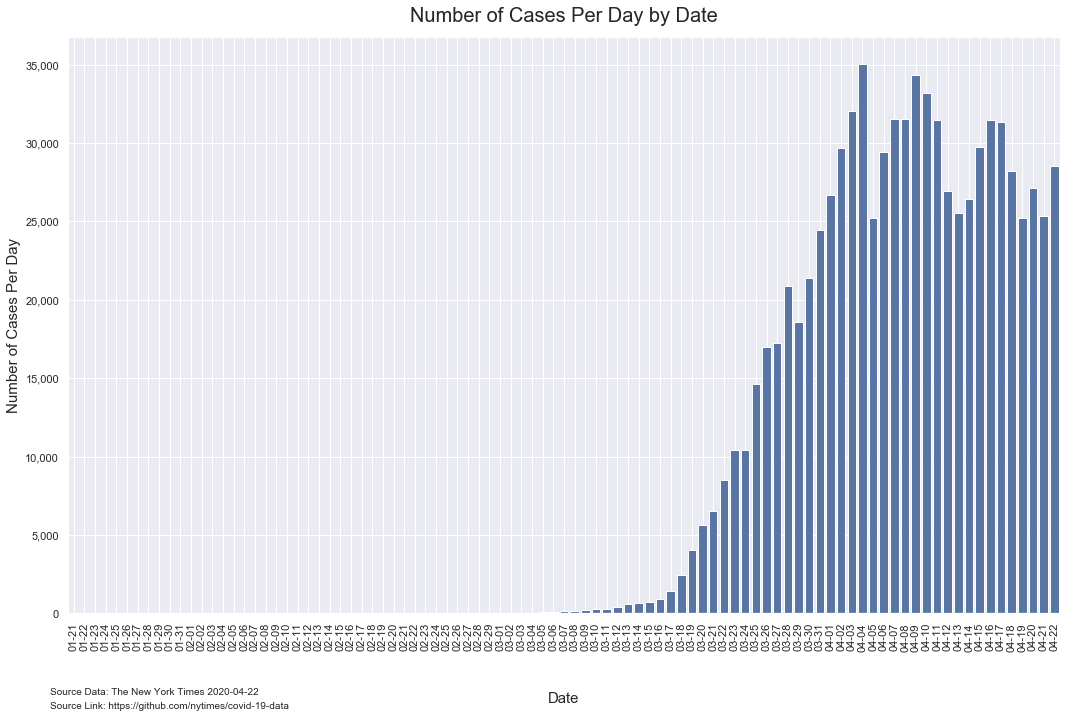

In [22]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

#ax1.legend_.remove()
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

In [23]:
epi_curve['3_day_rolling_average'] = epi_curve.daily_cases.rolling(3).mean()

In [24]:
epi_curve

date   cases NewDate  daily_cases  3_day_rolling_average
0  2020-01-21       1   01-21          1.0                    NaN
1  2020-01-22       1   01-22          0.0                    NaN
2  2020-01-23       1   01-23          0.0               0.333333
3  2020-01-24       2   01-24          1.0               0.333333
4  2020-01-25       3   01-25          1.0               0.666667
..        ...     ...     ...          ...                    ...
88 2020-04-18  728094   04-18      28241.0           30346.000000
89 2020-04-19  753314   04-19      25220.0           28260.333333
90 2020-04-20  780449   04-20      27135.0           26865.333333
91 2020-04-21  805771   04-21      25322.0           25892.333333
92 2020-04-22  834340   04-22      28569.0           27008.666667

[93 rows x 5 columns]

In [25]:
epi_curve['3_day_rolling_average'].fillna(0, inplace=True)

In [26]:
epi_curve.head()

date  cases NewDate  daily_cases  3_day_rolling_average
0 2020-01-21      1   01-21          1.0               0.000000
1 2020-01-22      1   01-22          0.0               0.000000
2 2020-01-23      1   01-23          0.0               0.333333
3 2020-01-24      2   01-24          1.0               0.333333
4 2020-01-25      3   01-25          1.0               0.666667

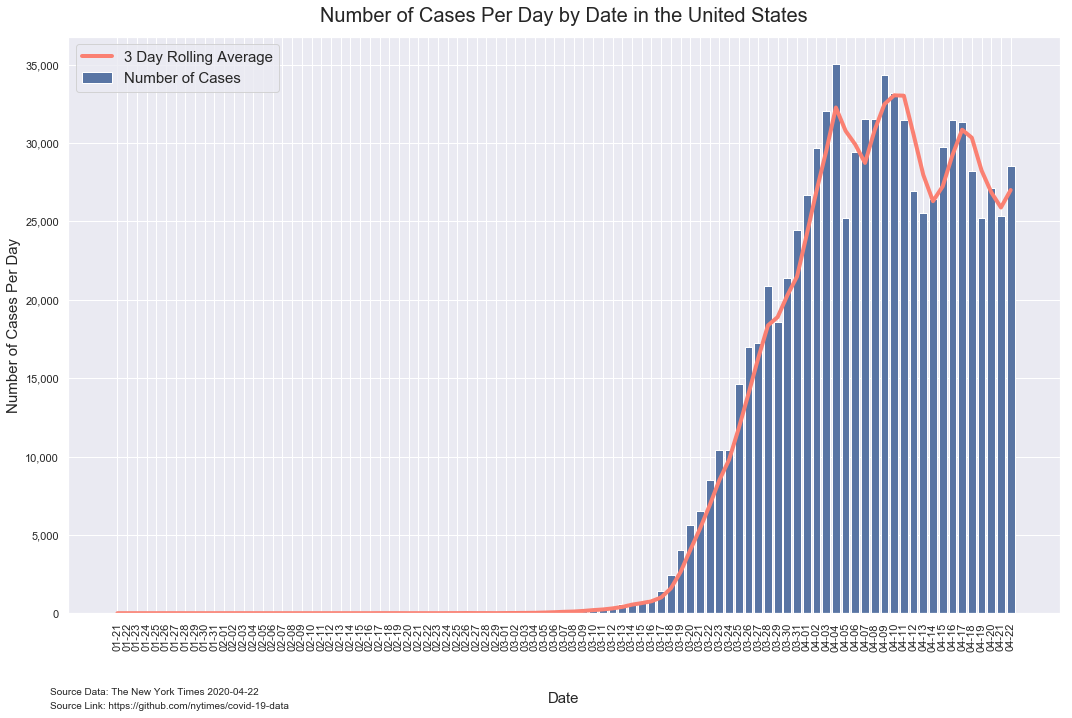

In [27]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="daily_cases",
            color="C0",
            data=epi_curve,
            label = 'Number of Cases')

sns.lineplot(x="NewDate", 
            y="3_day_rolling_average",
            color="salmon",
            data=epi_curve, linewidth=4,
            label = '3 Day Rolling Average')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('D'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

leg = ax1.legend(loc='upper left', fontsize=15)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date in the United States', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/epi_curve')

In [28]:
drop_duplicates = covid_19_state_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="state", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.state)
top_10  = covid_19_state_data.loc[covid_19_state_data['state'].isin(top10_list)]

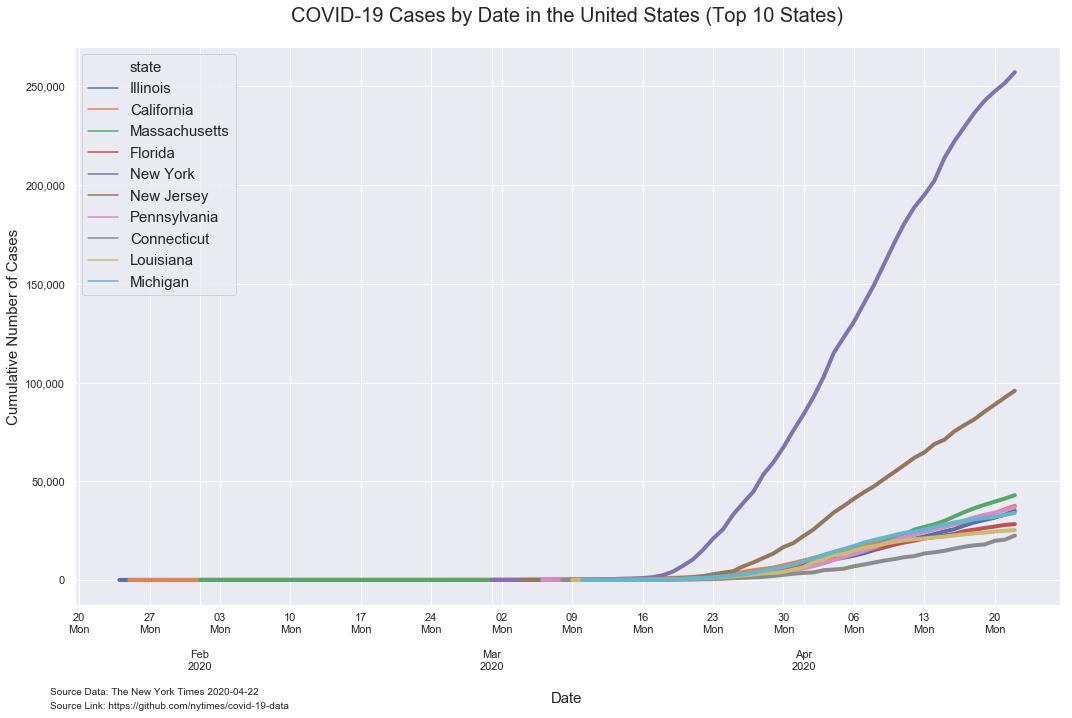

In [29]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="state",
             data=top_10, linewidth=4)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date in the United States (Top 10 States)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-timeseries')

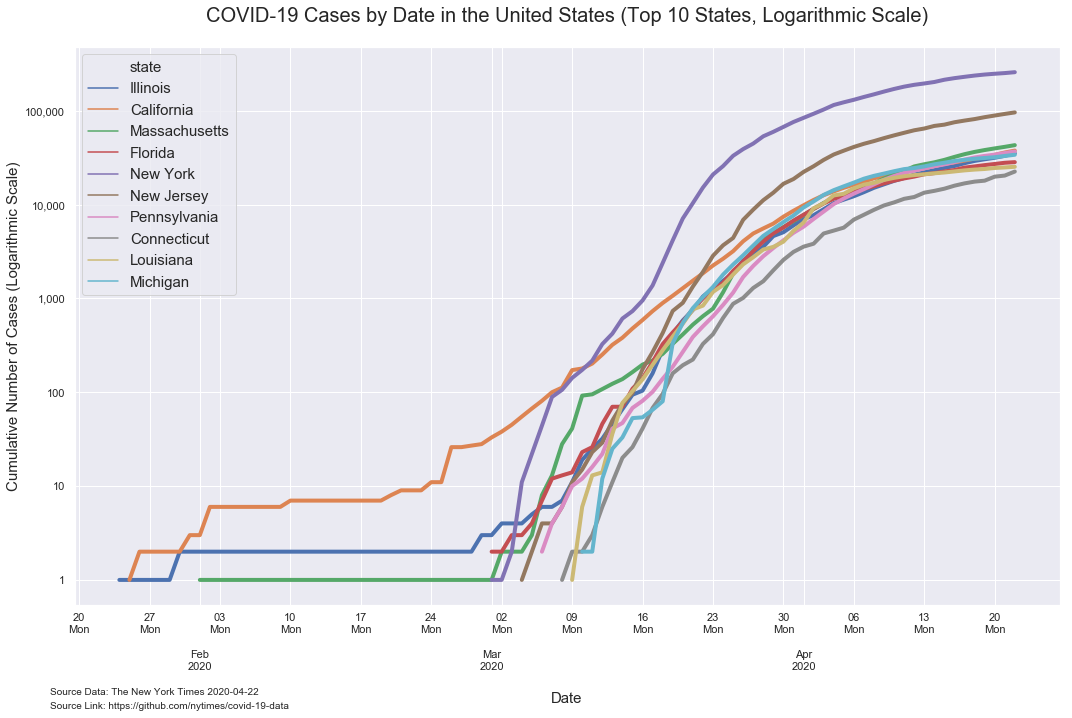

In [30]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="state",
             data=top_10, linewidth=4)
ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date in the United States (Top 10 States, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-timeseries-log')

# Date to 10 Cases

In [31]:
state_ten_cases = top_10.loc[top_10.cases >= 10]

In [32]:
state_ten_cases = state_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="state", 
                                                                                      keep = 'first').reset_index(drop=True)

In [33]:
state_ten_cases = state_ten_cases[['date', 'state']]
state_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [34]:
state_ten_cases

date_ten_case          state
0    2020-02-24     California
1    2020-03-04       New York
2    2020-03-07        Florida
3    2020-03-07  Massachusetts
4    2020-03-09   Pennsylvania
5    2020-03-09       Illinois
6    2020-03-09     New Jersey
7    2020-03-11      Louisiana
8    2020-03-12       Michigan
9    2020-03-13    Connecticut

In [35]:
state_ten_cases = top_10.merge(state_ten_cases, left_on='state', right_on='state')

In [36]:
state_ten_cases

date     state  fips  cases  deaths date_ten_case
0   2020-01-24  Illinois    17      1       0    2020-03-09
1   2020-01-25  Illinois    17      1       0    2020-03-09
2   2020-01-26  Illinois    17      1       0    2020-03-09
3   2020-01-27  Illinois    17      1       0    2020-03-09
4   2020-01-28  Illinois    17      1       0    2020-03-09
..         ...       ...   ...    ...     ...           ...
595 2020-04-18  Michigan    26  30717    2307    2020-03-12
596 2020-04-19  Michigan    26  31348    2389    2020-03-12
597 2020-04-20  Michigan    26  31927    2466    2020-03-12
598 2020-04-21  Michigan    26  32935    2698    2020-03-12
599 2020-04-22  Michigan    26  33929    2812    2020-03-12

[600 rows x 6 columns]

In [37]:
state_ten_cases = state_ten_cases.loc[state_ten_cases.cases >= 10]

In [38]:
state_ten_cases

date     state  fips  cases  deaths date_ten_case
45  2020-03-09  Illinois    17     11       0    2020-03-09
46  2020-03-10  Illinois    17     19       0    2020-03-09
47  2020-03-11  Illinois    17     25       0    2020-03-09
48  2020-03-12  Illinois    17     32       0    2020-03-09
49  2020-03-13  Illinois    17     46       0    2020-03-09
..         ...       ...   ...    ...     ...           ...
595 2020-04-18  Michigan    26  30717    2307    2020-03-12
596 2020-04-19  Michigan    26  31348    2389    2020-03-12
597 2020-04-20  Michigan    26  31927    2466    2020-03-12
598 2020-04-21  Michigan    26  32935    2698    2020-03-12
599 2020-04-22  Michigan    26  33929    2812    2020-03-12

[464 rows x 6 columns]

In [39]:
state_ten_cases['days_since_ten_case'] = (state_ten_cases['date'] - 
                                      state_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
state_ten_cases

date     state  fips  cases  deaths date_ten_case  \
45  2020-03-09  Illinois    17     11       0    2020-03-09   
46  2020-03-10  Illinois    17     19       0    2020-03-09   
47  2020-03-11  Illinois    17     25       0    2020-03-09   
48  2020-03-12  Illinois    17     32       0    2020-03-09   
49  2020-03-13  Illinois    17     46       0    2020-03-09   
..         ...       ...   ...    ...     ...           ...   
595 2020-04-18  Michigan    26  30717    2307    2020-03-12   
596 2020-04-19  Michigan    26  31348    2389    2020-03-12   
597 2020-04-20  Michigan    26  31927    2466    2020-03-12   
598 2020-04-21  Michigan    26  32935    2698    2020-03-12   
599 2020-04-22  Michigan    26  33929    2812    2020-03-12   

     days_since_ten_case  
45                     0  
46                     1  
47                     2  
48                     3  
49                     4  
..                   ...  
595                   37  
596                   38  
597                   39  
598                   40  
599                   41  

[464 rows x 7 columns]

# Daily Number of Cases Since 10th Case

In [41]:
state_ten_cases['daily_cases'] = (state_ten_cases.cases -
                                state_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
state_ten_cases[:50]

date       state  fips  cases  deaths date_ten_case  \
45  2020-03-09    Illinois    17     11       0    2020-03-09   
46  2020-03-10    Illinois    17     19       0    2020-03-09   
47  2020-03-11    Illinois    17     25       0    2020-03-09   
48  2020-03-12    Illinois    17     32       0    2020-03-09   
49  2020-03-13    Illinois    17     46       0    2020-03-09   
50  2020-03-14    Illinois    17     66       0    2020-03-09   
51  2020-03-15    Illinois    17     94       0    2020-03-09   
52  2020-03-16    Illinois    17    104       0    2020-03-09   
53  2020-03-17    Illinois    17    159       1    2020-03-09   
54  2020-03-18    Illinois    17    286       1    2020-03-09   
55  2020-03-19    Illinois    17    420       4    2020-03-09   
56  2020-03-20    Illinois    17    583       5    2020-03-09   
57  2020-03-21    Illinois    17    751       6    2020-03-09   
58  2020-03-22    Illinois    17   1047       9    2020-03-09   
59  2020-03-23    Illinois    17   1285      12    2020-03-09   
60  2020-03-24    Illinois    17   1535      16    2020-03-09   
61  2020-03-25    Illinois    17   1875      21    2020-03-09   
62  2020-03-26    Illinois    17   2538      26    2020-03-09   
63  2020-03-27    Illinois    17   3029      37    2020-03-09   
64  2020-03-28    Illinois    17   3547      50    2020-03-09   
65  2020-03-29    Illinois    17   4613      70    2020-03-09   
66  2020-03-30    Illinois    17   5070      84    2020-03-09   
67  2020-03-31    Illinois    17   5994     107    2020-03-09   
68  2020-04-01    Illinois    17   6980     146    2020-03-09   
69  2020-04-02    Illinois    17   7695     165    2020-03-09   
70  2020-04-03    Illinois    17   8904     211    2020-03-09   
71  2020-04-04    Illinois    17  10357     248    2020-03-09   
72  2020-04-05    Illinois    17  11276     282    2020-03-09   
73  2020-04-06    Illinois    17  12262     309    2020-03-09   
74  2020-04-07    Illinois    17  13549     384    2020-03-09   
75  2020-04-08    Illinois    17  15078     464    2020-03-09   
76  2020-04-09    Illinois    17  16422     534    2020-03-09   
77  2020-04-10    Illinois    17  17887     607    2020-03-09   
78  2020-04-11    Illinois    17  19180     682    2020-03-09   
79  2020-04-12    Illinois    17  20852     727    2020-03-09   
80  2020-04-13    Illinois    17  22025     800    2020-03-09   
81  2020-04-14    Illinois    17  23247     878    2020-03-09   
82  2020-04-15    Illinois    17  24593     958    2020-03-09   
83  2020-04-16    Illinois    17  25734    1081    2020-03-09   
84  2020-04-17    Illinois    17  27575    1142    2020-03-09   
85  2020-04-18    Illinois    17  29160    1272    2020-03-09   
86  2020-04-19    Illinois    17  30357    1302    2020-03-09   
87  2020-04-20    Illinois    17  31508    1359    2020-03-09   
88  2020-04-21    Illinois    17  33059    1479    2020-03-09   
89  2020-04-22    Illinois    17  35108    1577    2020-03-09   
120 2020-02-24  California     6     11       0    2020-02-24   
121 2020-02-25  California     6     11       0    2020-02-24   
122 2020-02-26  California     6     26       0    2020-02-24   
123 2020-02-27  California     6     26       0    2020-02-24   
124 2020-02-28  California     6     27       0    2020-02-24   

     days_since_ten_case  daily_cases  
45                     0          NaN  
46                     1          8.0  
47                     2          6.0  
48                     3          7.0  
49                     4         14.0  
50                     5         20.0  
51                     6         28.0  
52                     7         10.0  
53                     8         55.0  
54                     9        127.0  
55                    10        134.0  
56                    11        163.0  
57                    12        168.0  
58                    13        296.0  
59                    14        238.0  
60                    15        250.0  
61            

In [43]:
state_ten_cases.columns

Index(['date', 'state', 'fips', 'cases', 'deaths', 'date_ten_case',
       'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [44]:
state_ten_cases = state_ten_cases[['date', 'state', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [45]:
state_ten_cases[250:300]

date         state  cases  daily_cases  deaths date_ten_case  \
374 2020-03-11    New Jersey     23          8.0       1    2020-03-09   
375 2020-03-12    New Jersey     29          6.0       1    2020-03-09   
376 2020-03-13    New Jersey     50         21.0       1    2020-03-09   
377 2020-03-14    New Jersey     75         25.0       2    2020-03-09   
378 2020-03-15    New Jersey     98         23.0       2    2020-03-09   
379 2020-03-16    New Jersey    176         78.0       3    2020-03-09   
380 2020-03-17    New Jersey    268         92.0       3    2020-03-09   
381 2020-03-18    New Jersey    427        159.0       5    2020-03-09   
382 2020-03-19    New Jersey    735        308.0       9    2020-03-09   
383 2020-03-20    New Jersey    896        161.0      11    2020-03-09   
384 2020-03-21    New Jersey   1336        440.0      16    2020-03-09   
385 2020-03-22    New Jersey   1914        578.0      20    2020-03-09   
386 2020-03-23    New Jersey   2844        930.0      27    2020-03-09   
387 2020-03-24    New Jersey   3675        831.0      44    2020-03-09   
388 2020-03-25    New Jersey   4402        727.0      62    2020-03-09   
389 2020-03-26    New Jersey   6876       2474.0      81    2020-03-09   
390 2020-03-27    New Jersey   8825       1949.0     108    2020-03-09   
391 2020-03-28    New Jersey  11124       2299.0     140    2020-03-09   
392 2020-03-29    New Jersey  13386       2262.0     161    2020-03-09   
393 2020-03-30    New Jersey  16636       3250.0     199    2020-03-09   
394 2020-03-31    New Jersey  18696       2060.0     267    2020-03-09   
395 2020-04-01    New Jersey  22255       3559.0     355    2020-03-09   
396 2020-04-02    New Jersey  25590       3335.0     539    2020-03-09   
397 2020-04-03    New Jersey  29895       4305.0     647    2020-03-09   
398 2020-04-04    New Jersey  34124       4229.0     847    2020-03-09   
399 2020-04-05    New Jersey  37505       3381.0     917    2020-03-09   
400 2020-04-06    New Jersey  41090       3585.0    1005    2020-03-09   
401 2020-04-07    New Jersey  44416       3326.0    1232    2020-03-09   
402 2020-04-08    New Jersey  47437       3021.0    1504    2020-03-09   
403 2020-04-09    New Jersey  51027       3590.0    1700    2020-03-09   
404 2020-04-10    New Jersey  54588       3561.0    1932    2020-03-09   
405 2020-04-11    New Jersey  58151       3563.0    2183    2020-03-09   
406 2020-04-12    New Jersey  61850       3699.0    2350    2020-03-09   
407 2020-04-13    New Jersey  64584       2734.0    2443    2020-03-09   
408 2020-04-14    New Jersey  68824       4240.0    2805    2020-03-09   
409 2020-04-15    New Jersey  71030       2206.0    3156    2020-03-09   
410 2020-04-16    New Jersey  75317       4287.0    3518    2020-03-09   
411 2020-04-17    New Jersey  78467       3150.0    3840    2020-03-09   
412 2020-04-18    New Jersey  81420       2953.0    4070    2020-03-09   
413 2020-04-19    New Jersey  85301       3881.0    4202    2020-03-09   
414 2020-04-20    New Jersey  88806       3505.0    4377    2020-03-09   
415 2020-04-21    New Jersey  92387       3581.0    4753    2020-03-09   
416 2020-04-22    New Jersey  95865       3478.0    5063    2020-03-09   
420 2020-03-09  Pennsylvania     10     -95855.0       0    2020-03-09   
421 2020-03-10  Pennsylvania     12          2.0       0    2020-03-09   
422 2020-03-11  Pennsylvania     16          4.0       0    2020-03-09   
423 2020-03-12  Pennsylvania     22          6.0       0    2020-03-09   
424 2020-03-13  Pennsylvania     41         19.0       0    2020-03-09   
425 2020-03-14  Pennsylvania     47          6.0       0    2020-03-09   
426 2020-03-15  Pennsylvania     68         21.0       0    2020-03-09   

     days_since_ten_case  
374                    2  
375                    3  
376                    4  
377                    5  
378                    6  
379                    7  
380                    8  
381                

In [46]:
state_ten_cases['daily_cases'].loc[state_ten_cases.daily_cases < 0] = state_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
state_ten_cases['daily_cases'].loc[state_ten_cases.daily_cases.isnull()] = state_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
state_ten_cases[:50]

date       state  cases  daily_cases  deaths date_ten_case  \
45  2020-03-09    Illinois     11          1.0       0    2020-03-09   
46  2020-03-10    Illinois     19          8.0       0    2020-03-09   
47  2020-03-11    Illinois     25          6.0       0    2020-03-09   
48  2020-03-12    Illinois     32          7.0       0    2020-03-09   
49  2020-03-13    Illinois     46         14.0       0    2020-03-09   
50  2020-03-14    Illinois     66         20.0       0    2020-03-09   
51  2020-03-15    Illinois     94         28.0       0    2020-03-09   
52  2020-03-16    Illinois    104         10.0       0    2020-03-09   
53  2020-03-17    Illinois    159         55.0       1    2020-03-09   
54  2020-03-18    Illinois    286        127.0       1    2020-03-09   
55  2020-03-19    Illinois    420        134.0       4    2020-03-09   
56  2020-03-20    Illinois    583        163.0       5    2020-03-09   
57  2020-03-21    Illinois    751        168.0       6    2020-03-09   
58  2020-03-22    Illinois   1047        296.0       9    2020-03-09   
59  2020-03-23    Illinois   1285        238.0      12    2020-03-09   
60  2020-03-24    Illinois   1535        250.0      16    2020-03-09   
61  2020-03-25    Illinois   1875        340.0      21    2020-03-09   
62  2020-03-26    Illinois   2538        663.0      26    2020-03-09   
63  2020-03-27    Illinois   3029        491.0      37    2020-03-09   
64  2020-03-28    Illinois   3547        518.0      50    2020-03-09   
65  2020-03-29    Illinois   4613       1066.0      70    2020-03-09   
66  2020-03-30    Illinois   5070        457.0      84    2020-03-09   
67  2020-03-31    Illinois   5994        924.0     107    2020-03-09   
68  2020-04-01    Illinois   6980        986.0     146    2020-03-09   
69  2020-04-02    Illinois   7695        715.0     165    2020-03-09   
70  2020-04-03    Illinois   8904       1209.0     211    2020-03-09   
71  2020-04-04    Illinois  10357       1453.0     248    2020-03-09   
72  2020-04-05    Illinois  11276        919.0     282    2020-03-09   
73  2020-04-06    Illinois  12262        986.0     309    2020-03-09   
74  2020-04-07    Illinois  13549       1287.0     384    2020-03-09   
75  2020-04-08    Illinois  15078       1529.0     464    2020-03-09   
76  2020-04-09    Illinois  16422       1344.0     534    2020-03-09   
77  2020-04-10    Illinois  17887       1465.0     607    2020-03-09   
78  2020-04-11    Illinois  19180       1293.0     682    2020-03-09   
79  2020-04-12    Illinois  20852       1672.0     727    2020-03-09   
80  2020-04-13    Illinois  22025       1173.0     800    2020-03-09   
81  2020-04-14    Illinois  23247       1222.0     878    2020-03-09   
82  2020-04-15    Illinois  24593       1346.0     958    2020-03-09   
83  2020-04-16    Illinois  25734       1141.0    1081    2020-03-09   
84  2020-04-17    Illinois  27575       1841.0    1142    2020-03-09   
85  2020-04-18    Illinois  29160       1585.0    1272    2020-03-09   
86  2020-04-19    Illinois  30357       1197.0    1302    2020-03-09   
87  2020-04-20    Illinois  31508       1151.0    1359    2020-03-09   
88  2020-04-21    Illinois  33059       1551.0    1479    2020-03-09   
89  2020-04-22    Illinois  35108       2049.0    1577    2020-03-09   
120 2020-02-24  California     11          1.0       0    2020-02-24   
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   

     days_since_ten_case  
45                     0  
46                     1  
47                     2  
48                     3  
49                     4  
50                     5  
51                     6  
52                     7  
53                     8  
54                     9  
55                    10  
56           

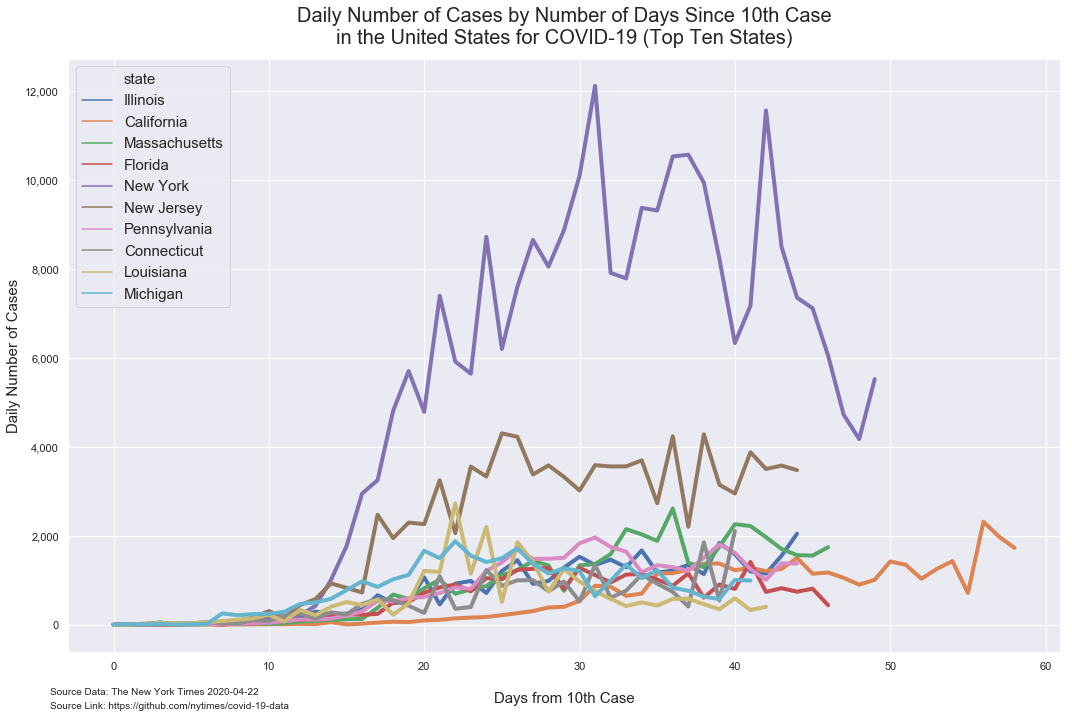

In [49]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="state",
             data=state_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state-top-10-daily')

In [50]:
state_ten_cases['daily_cases'].loc[state_ten_cases.daily_cases == 0]

121    0.0
123    0.0
274    0.0
420    0.0
Name: daily_cases, dtype: float64

In [51]:
temp_fill_zeros = state_ten_cases.sort_values(by=['state', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[state_ten_cases.daily_cases == 0] = 1

temp_fill_zeros

date         state  cases  daily_cases  deaths date_ten_case  \
120 2020-02-24    California     11          1.0       0    2020-02-24   
121 2020-02-25    California     11          1.0       0    2020-02-24   
122 2020-02-26    California     26         15.0       0    2020-02-24   
123 2020-02-27    California     26          1.0       0    2020-02-24   
124 2020-02-28    California     27          1.0       0    2020-02-24   
..         ...           ...    ...          ...     ...           ...   
460 2020-04-18  Pennsylvania  31742       1621.0    1150    2020-03-09   
461 2020-04-19  Pennsylvania  32992       1250.0    1285    2020-03-09   
462 2020-04-20  Pennsylvania  34005       1013.0    1366    2020-03-09   
463 2020-04-21  Pennsylvania  35384       1379.0    1620    2020-03-09   
464 2020-04-22  Pennsylvania  36763       1379.0    1720    2020-03-09   

     days_since_ten_case  
120                    0  
121                    1  
122                    2  
123                    3  
124                    4  
..                   ...  
460                   40  
461                   41  
462                   42  
463                   43  
464                   44  

[464 rows x 7 columns]

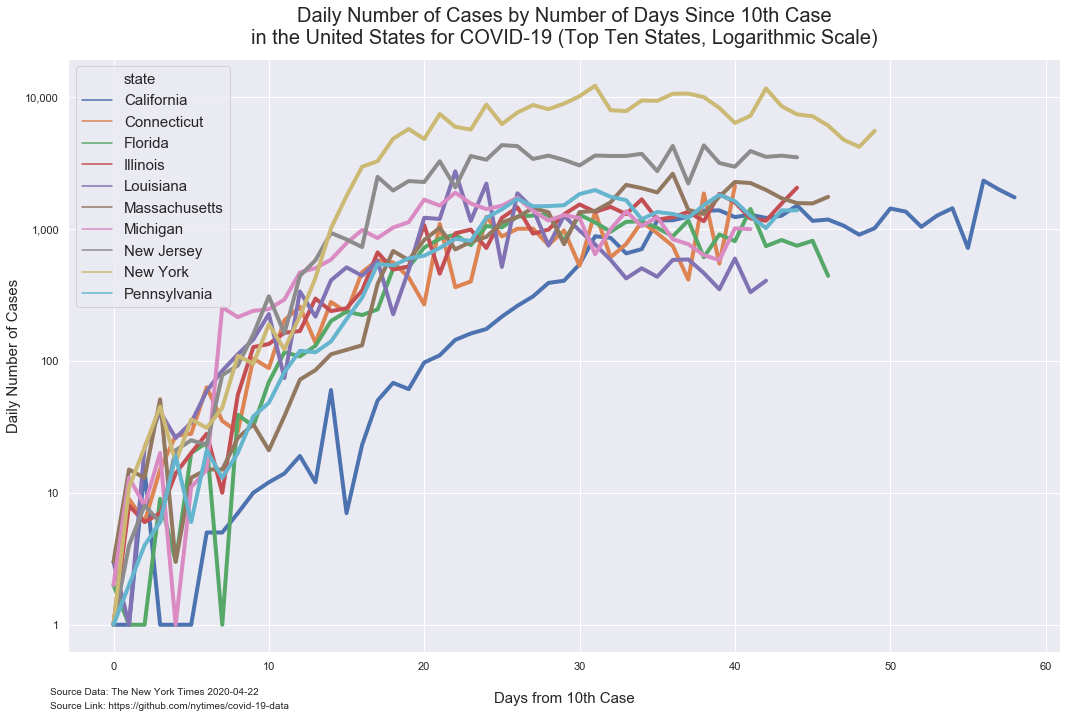

In [52]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="state",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state-top-10-daily-log')

In [53]:
state_ten_cases['daily_cases'].loc[state_ten_cases.daily_cases == 0]

121    0.0
123    0.0
274    0.0
420    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [54]:
state_ten_cases_weekly = state_ten_cases.sort_values(by=['state', 'date','cases'], 
                                                    ascending=[True, True, True])

In [55]:
state_ten_cases_weekly[0:30]

date       state  cases  daily_cases  deaths date_ten_case  \
120 2020-02-24  California     11          1.0       0    2020-02-24   
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   
125 2020-02-29  California     28          1.0       0    2020-02-24   
126 2020-03-01  California     33          5.0       0    2020-02-24   
127 2020-03-02  California     38          5.0       0    2020-02-24   
128 2020-03-03  California     45          7.0       0    2020-02-24   
129 2020-03-04  California     55         10.0       1    2020-02-24   
130 2020-03-05  California     67         12.0       1    2020-02-24   
131 2020-03-06  California     81         14.0       1    2020-02-24   
132 2020-03-07  California    100         19.0       1    2020-02-24   
133 2020-03-08  California    112         12.0       1    2020-02-24   
134 2020-03-09  California    172         60.0       2    2020-02-24   
135 2020-03-10  California    179          7.0       3    2020-02-24   
136 2020-03-11  California    202         23.0       4    2020-02-24   
137 2020-03-12  California    252         50.0       4    2020-02-24   
138 2020-03-13  California    320         68.0       5    2020-02-24   
139 2020-03-14  California    381         61.0       5    2020-02-24   
140 2020-03-15  California    478         97.0       6    2020-02-24   
141 2020-03-16  California    588        110.0      11    2020-02-24   
142 2020-03-17  California    732        144.0      14    2020-02-24   
143 2020-03-18  California    893        161.0      17    2020-02-24   
144 2020-03-19  California   1067        174.0      19    2020-02-24   
145 2020-03-20  California   1283        216.0      24    2020-02-24   
146 2020-03-21  California   1544        261.0      28    2020-02-24   
147 2020-03-22  California   1851        307.0      35    2020-02-24   
148 2020-03-23  California   2240        389.0      39    2020-02-24   
149 2020-03-24  California   2644        404.0      52    2020-02-24   

     days_since_ten_case  
120                    0  
121                    1  
122                    2  
123                    3  
124                    4  
125                    5  
126                    6  
127                    7  
128                    8  
129                    9  
130                   10  
131                   11  
132                   12  
133                   13  
134                   14  
135                   15  
136                   16  
137                   17  
138                   18  
139                   19  
140                   20  
141                   21  
142                   22  
143                   23  
144                   24  
145                   25  
146                   26  
147                   27  
148                   28  
149                   29

In [56]:
state_ten_cases_weekly = state_ten_cases_weekly.set_index('date').groupby('state').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [57]:
state_ten_cases_weekly

days_since_ten_case  daily_cases
state        date                                        
California   2020-03-01                    6     3.285714
             2020-03-08                   13    11.285714
             2020-03-15                   20    52.285714
             2020-03-22                   27   196.142857
             2020-03-29                   34   630.714286
...                                      ...          ...
Pennsylvania 2020-03-29                   20   419.571429
             2020-04-05                   27  1164.000000
             2020-04-12                   34  1623.714286
             2020-04-19                   41  1433.857143
             2020-04-26                   44  1257.000000

[75 rows x 2 columns]

In [58]:
state_ten_cases_weekly.reset_index(inplace=True)
state_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [59]:
state_ten_cases_weekly

state       date  days_since_ten_case  daily_cases_week_average
0     California 2020-03-01                    6                  3.285714
1     California 2020-03-08                   13                 11.285714
2     California 2020-03-15                   20                 52.285714
3     California 2020-03-22                   27                196.142857
4     California 2020-03-29                   34                630.714286
..           ...        ...                  ...                       ...
70  Pennsylvania 2020-03-29                   20                419.571429
71  Pennsylvania 2020-04-05                   27               1164.000000
72  Pennsylvania 2020-04-12                   34               1623.714286
73  Pennsylvania 2020-04-19                   41               1433.857143
74  Pennsylvania 2020-04-26                   44               1257.000000

[75 rows x 4 columns]

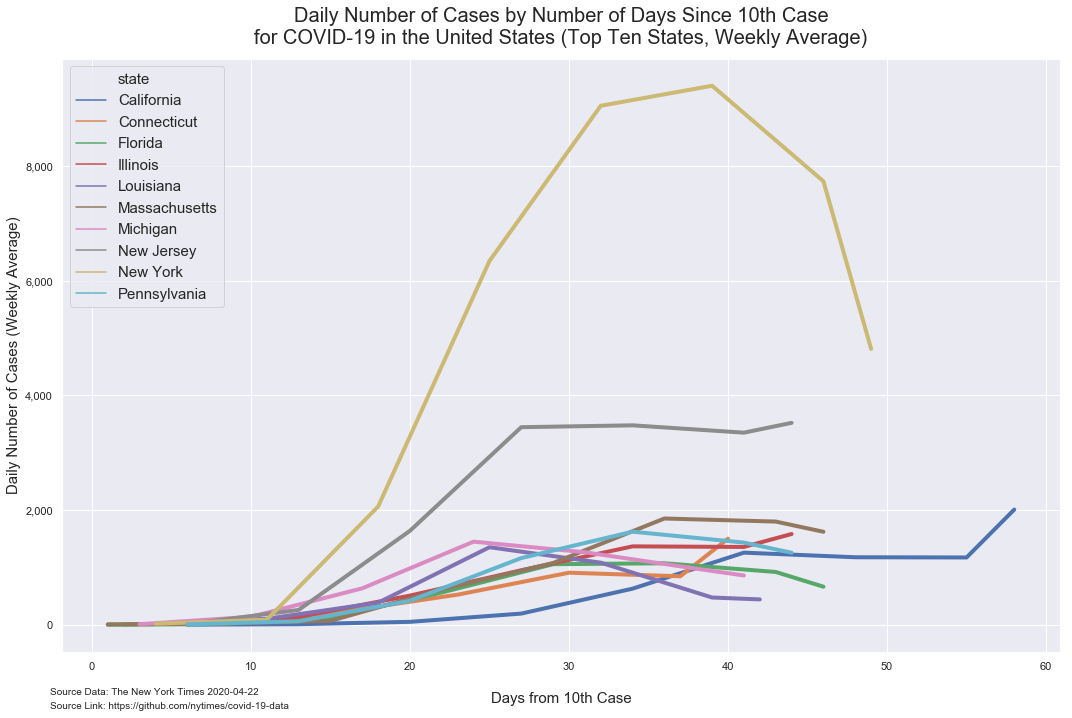

In [60]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="state",
             data=state_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state-top-10-weekly')

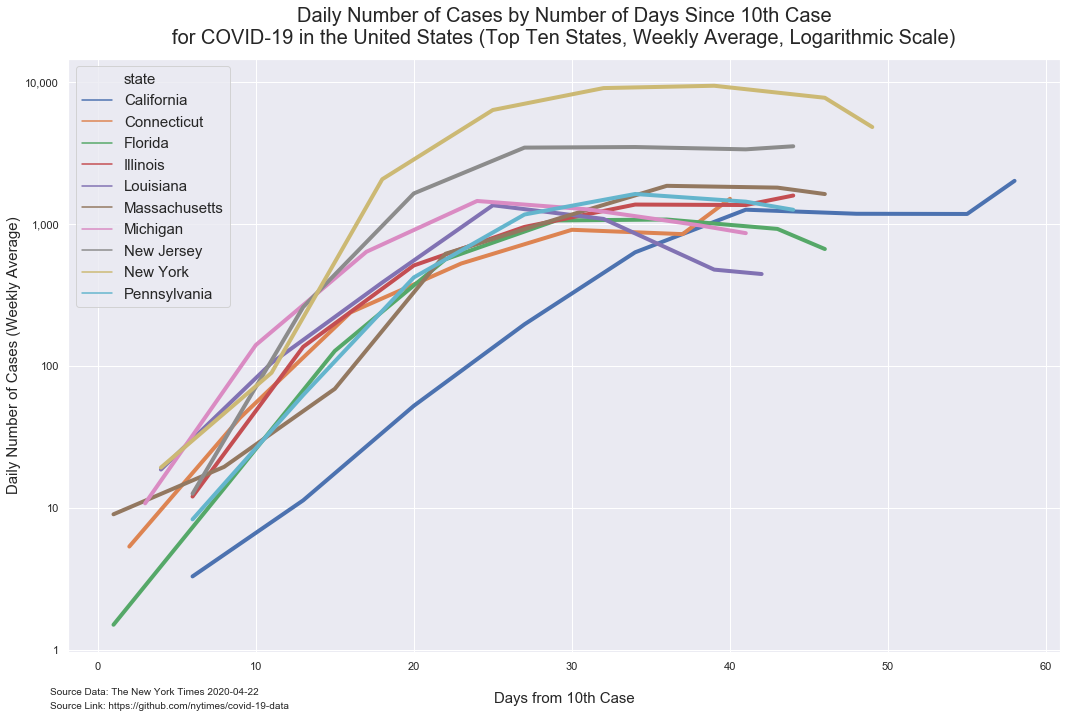

In [61]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="state",
             data=state_ten_cases_weekly, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [62]:
growth_rate = state_ten_cases.sort_values(by=['state', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [63]:
growth_rate.head()

date       state  cases  daily_cases  deaths date_ten_case  \
120 2020-02-24  California     11          1.0       0    2020-02-24   
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   

     days_since_ten_case  
120                    0  
121                    1  
122                    2  
123                    3  
124                    4

In [64]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [65]:
growth_rate[50:100]

date        state  cases  daily_cases  deaths date_ten_case  \
170 2020-04-14   California  25758       1424.0     778    2020-02-24   
171 2020-04-15   California  27107       1349.0     885    2020-02-24   
172 2020-04-16   California  28142       1035.0     971    2020-02-24   
173 2020-04-17   California  29398       1256.0    1050    2020-02-24   
174 2020-04-18   California  30829       1431.0    1146    2020-02-24   
175 2020-04-19   California  31544        715.0    1176    2020-02-24   
176 2020-04-20   California  33862       2318.0    1223    2020-02-24   
177 2020-04-21   California  35844       1982.0    1316    2020-02-24   
178 2020-04-22   California  37573       1729.0    1425    2020-02-24   
470 2020-03-13  Connecticut     11          1.0       0    2020-03-13   
471 2020-03-14  Connecticut     20          9.0       0    2020-03-13   
472 2020-03-15  Connecticut     26          6.0       0    2020-03-13   
473 2020-03-16  Connecticut     41         15.0       0    2020-03-13   
474 2020-03-17  Connecticut     68         27.0       0    2020-03-13   
475 2020-03-18  Connecticut     96         28.0       1    2020-03-13   
476 2020-03-19  Connecticut    159         63.0       4    2020-03-13   
477 2020-03-20  Connecticut    194         35.0       4    2020-03-13   
478 2020-03-21  Connecticut    223         29.0       5    2020-03-13   
479 2020-03-22  Connecticut    327        104.0       8    2020-03-13   
480 2020-03-23  Connecticut    415         88.0      10    2020-03-13   
481 2020-03-24  Connecticut    618        203.0      12    2020-03-13   
482 2020-03-25  Connecticut    875        257.0      19    2020-03-13   
483 2020-03-26  Connecticut   1012        137.0      21    2020-03-13   
484 2020-03-27  Connecticut   1291        279.0      27    2020-03-13   
485 2020-03-28  Connecticut   1524        233.0      33    2020-03-13   
486 2020-03-29  Connecticut   1993        469.0      34    2020-03-13   
487 2020-03-30  Connecticut   2571        578.0      36    2020-03-13   
488 2020-03-31  Connecticut   3128        557.0      69    2020-03-13   
489 2020-04-01  Connecticut   3557        429.0      85    2020-03-13   
490 2020-04-02  Connecticut   3824        267.0     112    2020-03-13   
491 2020-04-03  Connecticut   4915       1091.0     132    2020-03-13   
492 2020-04-04  Connecticut   5276        361.0     165    2020-03-13   
493 2020-04-05  Connecticut   5675        399.0     189    2020-03-13   
494 2020-04-06  Connecticut   6906       1231.0     206    2020-03-13   
495 2020-04-07  Connecticut   7781        875.0     277    2020-03-13   
496 2020-04-08  Connecticut   8781       1000.0     335    2020-03-13   
497 2020-04-09  Connecticut   9784       1003.0     380    2020-03-13   
498 2020-04-10  Connecticut  10538        754.0     448    2020-03-13   
499 2020-04-11  Connecticut  11510        972.0     494    2020-03-13   
500 2020-04-12  Connecticut  12035        525.0     554    2020-03-13   
501 2020-04-13  Connecticut  13381       1346.0     602    2020-03-13   
502 2020-04-14  Connecticut  13989        608.0     671    2020-03-13   
503 2020-04-15  Connecticut  14755        766.0     868    2020-03-13   
504 2020-04-16  Connecticut  15884       1129.0     971    2020-03-13   
505 2020-04-17  Connecticut  16809        925.0    1036    2020-03-13   
506 2020-04-18  Connecticut  17550        741.0    1086    2020-03-13   
507 2020-04-19  Connecticut  17962        412.0    1127    2020-03-13   
508 2020-04-20  Connecticut  19815       1853.0    1331    2020-03-13   
509 2020-04-21  Connecticut  20360        545.0    1423    2020-03-13   
510 2020-04-22  Connecticut  22469       2109.0    1544    2020-03-13   

     days_since_ten_case  growth_rate  
170                   50     1.408506  
171                   51     0.947331  
172                   52     0.767235  
173                   53     1.213527  
174                   54     1.139331  
175                   55     0.499651  
176   

In [66]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [67]:
growth_rate[:50]

date       state  cases  daily_cases  deaths date_ten_case  \
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   
125 2020-02-29  California     28          1.0       0    2020-02-24   
126 2020-03-01  California     33          5.0       0    2020-02-24   
127 2020-03-02  California     38          5.0       0    2020-02-24   
128 2020-03-03  California     45          7.0       0    2020-02-24   
129 2020-03-04  California     55         10.0       1    2020-02-24   
130 2020-03-05  California     67         12.0       1    2020-02-24   
131 2020-03-06  California     81         14.0       1    2020-02-24   
132 2020-03-07  California    100         19.0       1    2020-02-24   
133 2020-03-08  California    112         12.0       1    2020-02-24   
134 2020-03-09  California    172         60.0       2    2020-02-24   
135 2020-03-10  California    179          7.0       3    2020-02-24   
136 2020-03-11  California    202         23.0       4    2020-02-24   
137 2020-03-12  California    252         50.0       4    2020-02-24   
138 2020-03-13  California    320         68.0       5    2020-02-24   
139 2020-03-14  California    381         61.0       5    2020-02-24   
140 2020-03-15  California    478         97.0       6    2020-02-24   
141 2020-03-16  California    588        110.0      11    2020-02-24   
142 2020-03-17  California    732        144.0      14    2020-02-24   
143 2020-03-18  California    893        161.0      17    2020-02-24   
144 2020-03-19  California   1067        174.0      19    2020-02-24   
145 2020-03-20  California   1283        216.0      24    2020-02-24   
146 2020-03-21  California   1544        261.0      28    2020-02-24   
147 2020-03-22  California   1851        307.0      35    2020-02-24   
148 2020-03-23  California   2240        389.0      39    2020-02-24   
149 2020-03-24  California   2644        404.0      52    2020-02-24   
150 2020-03-25  California   3183        539.0      67    2020-02-24   
151 2020-03-26  California   4060        877.0      82    2020-02-24   
152 2020-03-27  California   4914        854.0     102    2020-02-24   
153 2020-03-28  California   5565        651.0     121    2020-02-24   
154 2020-03-29  California   6266        701.0     130    2020-02-24   
155 2020-03-30  California   7421       1155.0     146    2020-02-24   
156 2020-03-31  California   8582       1161.0     183    2020-02-24   
157 2020-04-01  California   9816       1234.0     212    2020-02-24   
158 2020-04-02  California  11190       1374.0     247    2020-02-24   
159 2020-04-03  California  12569       1379.0     282    2020-02-24   
160 2020-04-04  California  13796       1227.0     323    2020-02-24   
161 2020-04-05  California  15076       1280.0     349    2020-02-24   
162 2020-04-06  California  16284       1208.0     386    2020-02-24   
163 2020-04-07  California  17540       1256.0     447    2020-02-24   
164 2020-04-08  California  19043       1503.0     506    2020-02-24   
165 2020-04-09  California  20191       1148.0     548    2020-02-24   
166 2020-04-10  California  21366       1175.0     594    2020-02-24   
167 2020-04-11  California  22421       1055.0     632    2020-02-24   
168 2020-04-12  California  23323        902.0     676    2020-02-24   
169 2020-04-13  California  24334       1011.0     725    2020-02-24   
170 2020-04-14  California  25758       1424.0     778    2020-02-24   

     days_since_ten_case  growth_rate  
121                    1     0.000000  
122                    2          inf  
123                    3     0.000000  
124                    4          inf  
125                    5     1.000000  
126                    6     5.000000  
127                    7     1.000000  
128              

In [68]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [69]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [70]:
growth_rate[:50]

date       state  cases  daily_cases  deaths date_ten_case  \
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   
125 2020-02-29  California     28          1.0       0    2020-02-24   
126 2020-03-01  California     33          5.0       0    2020-02-24   
127 2020-03-02  California     38          5.0       0    2020-02-24   
128 2020-03-03  California     45          7.0       0    2020-02-24   
129 2020-03-04  California     55         10.0       1    2020-02-24   
130 2020-03-05  California     67         12.0       1    2020-02-24   
131 2020-03-06  California     81         14.0       1    2020-02-24   
132 2020-03-07  California    100         19.0       1    2020-02-24   
133 2020-03-08  California    112         12.0       1    2020-02-24   
134 2020-03-09  California    172         60.0       2    2020-02-24   
135 2020-03-10  California    179          7.0       3    2020-02-24   
136 2020-03-11  California    202         23.0       4    2020-02-24   
137 2020-03-12  California    252         50.0       4    2020-02-24   
138 2020-03-13  California    320         68.0       5    2020-02-24   
139 2020-03-14  California    381         61.0       5    2020-02-24   
140 2020-03-15  California    478         97.0       6    2020-02-24   
141 2020-03-16  California    588        110.0      11    2020-02-24   
142 2020-03-17  California    732        144.0      14    2020-02-24   
143 2020-03-18  California    893        161.0      17    2020-02-24   
144 2020-03-19  California   1067        174.0      19    2020-02-24   
145 2020-03-20  California   1283        216.0      24    2020-02-24   
146 2020-03-21  California   1544        261.0      28    2020-02-24   
147 2020-03-22  California   1851        307.0      35    2020-02-24   
148 2020-03-23  California   2240        389.0      39    2020-02-24   
149 2020-03-24  California   2644        404.0      52    2020-02-24   
150 2020-03-25  California   3183        539.0      67    2020-02-24   
151 2020-03-26  California   4060        877.0      82    2020-02-24   
152 2020-03-27  California   4914        854.0     102    2020-02-24   
153 2020-03-28  California   5565        651.0     121    2020-02-24   
154 2020-03-29  California   6266        701.0     130    2020-02-24   
155 2020-03-30  California   7421       1155.0     146    2020-02-24   
156 2020-03-31  California   8582       1161.0     183    2020-02-24   
157 2020-04-01  California   9816       1234.0     212    2020-02-24   
158 2020-04-02  California  11190       1374.0     247    2020-02-24   
159 2020-04-03  California  12569       1379.0     282    2020-02-24   
160 2020-04-04  California  13796       1227.0     323    2020-02-24   
161 2020-04-05  California  15076       1280.0     349    2020-02-24   
162 2020-04-06  California  16284       1208.0     386    2020-02-24   
163 2020-04-07  California  17540       1256.0     447    2020-02-24   
164 2020-04-08  California  19043       1503.0     506    2020-02-24   
165 2020-04-09  California  20191       1148.0     548    2020-02-24   
166 2020-04-10  California  21366       1175.0     594    2020-02-24   
167 2020-04-11  California  22421       1055.0     632    2020-02-24   
168 2020-04-12  California  23323        902.0     676    2020-02-24   
169 2020-04-13  California  24334       1011.0     725    2020-02-24   
170 2020-04-14  California  25758       1424.0     778    2020-02-24   

     days_since_ten_case  growth_rate  
121                    1     0.000000  
122                    2     0.000000  
123                    3     0.000000  
124                    4     0.000000  
125                    5     1.000000  
126                    6     5.000000  
127                    7     1.000000  
128              

In [71]:
growth_rate.isna().sum()

date                   0
state                  0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [72]:
growth_rate

date         state  cases  daily_cases  deaths date_ten_case  \
121 2020-02-25    California     11          0.0       0    2020-02-24   
122 2020-02-26    California     26         15.0       0    2020-02-24   
123 2020-02-27    California     26          0.0       0    2020-02-24   
124 2020-02-28    California     27          1.0       0    2020-02-24   
125 2020-02-29    California     28          1.0       0    2020-02-24   
..         ...           ...    ...          ...     ...           ...   
460 2020-04-18  Pennsylvania  31742       1621.0    1150    2020-03-09   
461 2020-04-19  Pennsylvania  32992       1250.0    1285    2020-03-09   
462 2020-04-20  Pennsylvania  34005       1013.0    1366    2020-03-09   
463 2020-04-21  Pennsylvania  35384       1379.0    1620    2020-03-09   
464 2020-04-22  Pennsylvania  36763       1379.0    1720    2020-03-09   

     days_since_ten_case  growth_rate  
121                    1     0.000000  
122                    2     0.000000  
123                    3     0.000000  
124                    4     0.000000  
125                    5     1.000000  
..                   ...          ...  
460                   40     0.897067  
461                   41     0.771129  
462                   42     0.810400  
463                   43     1.361303  
464                   44     1.000000  

[454 rows x 8 columns]

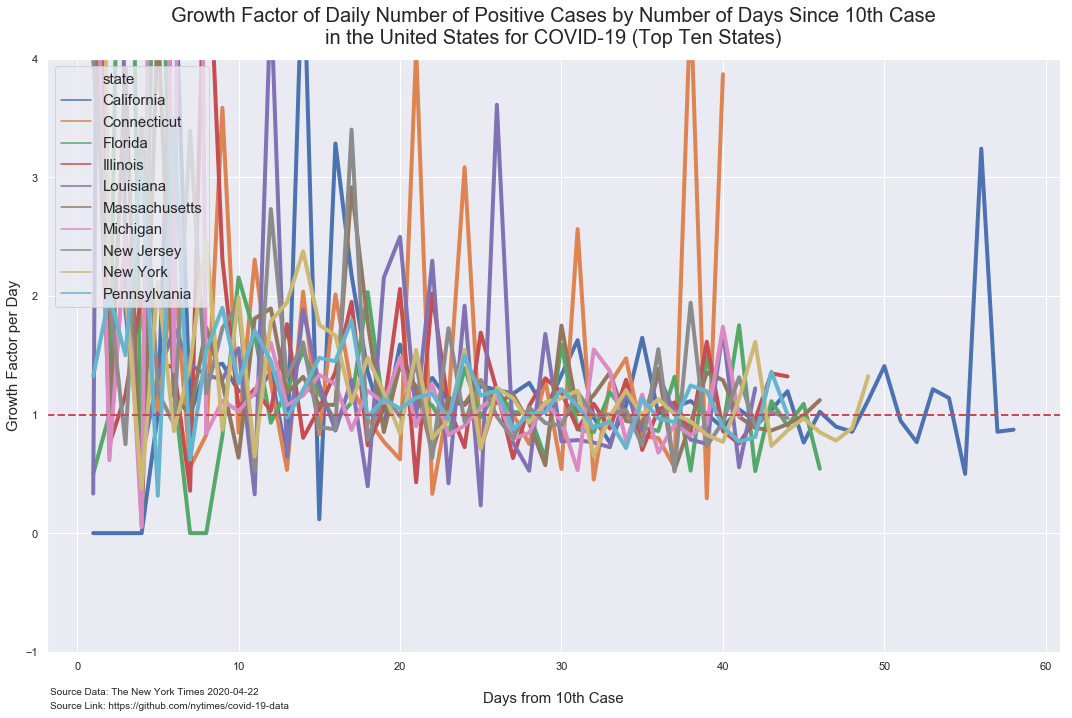

In [73]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="state", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 4)
#plt.xlim(-1, 8)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [74]:
growth_rate_weekly = growth_rate.set_index('date').groupby('state').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [75]:
growth_rate_weekly

days_since_ten_case  growth_rate
state        date                                        
California   2020-03-01                    6     1.000000
             2020-03-08                   13     1.169137
             2020-03-15                   20     2.060502
             2020-03-22                   27     1.181124
             2020-03-29                   34     1.154254
...                                      ...          ...
Pennsylvania 2020-03-29                   20     1.298609
             2020-04-05                   27     1.145220
             2020-04-12                   34     0.979286
             2020-04-19                   41     1.021069
             2020-04-26                   44     1.057234

[75 rows x 2 columns]

In [76]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [77]:
growth_rate_weekly

state       date  days_since_ten_case  growth_rate_weekly_average
0     California 2020-03-01                    6                    1.000000
1     California 2020-03-08                   13                    1.169137
2     California 2020-03-15                   20                    2.060502
3     California 2020-03-22                   27                    1.181124
4     California 2020-03-29                   34                    1.154254
..           ...        ...                  ...                         ...
70  Pennsylvania 2020-03-29                   20                    1.298609
71  Pennsylvania 2020-04-05                   27                    1.145220
72  Pennsylvania 2020-04-12                   34                    0.979286
73  Pennsylvania 2020-04-19                   41                    1.021069
74  Pennsylvania 2020-04-26                   44                    1.057234

[75 rows x 4 columns]

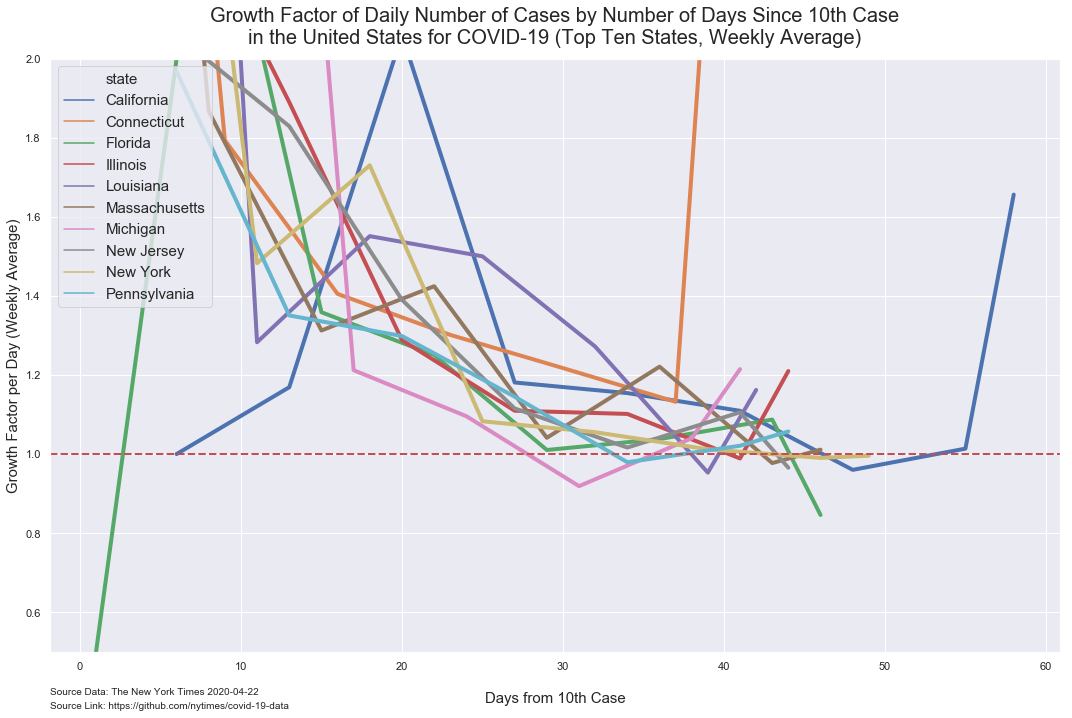

In [78]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="state", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

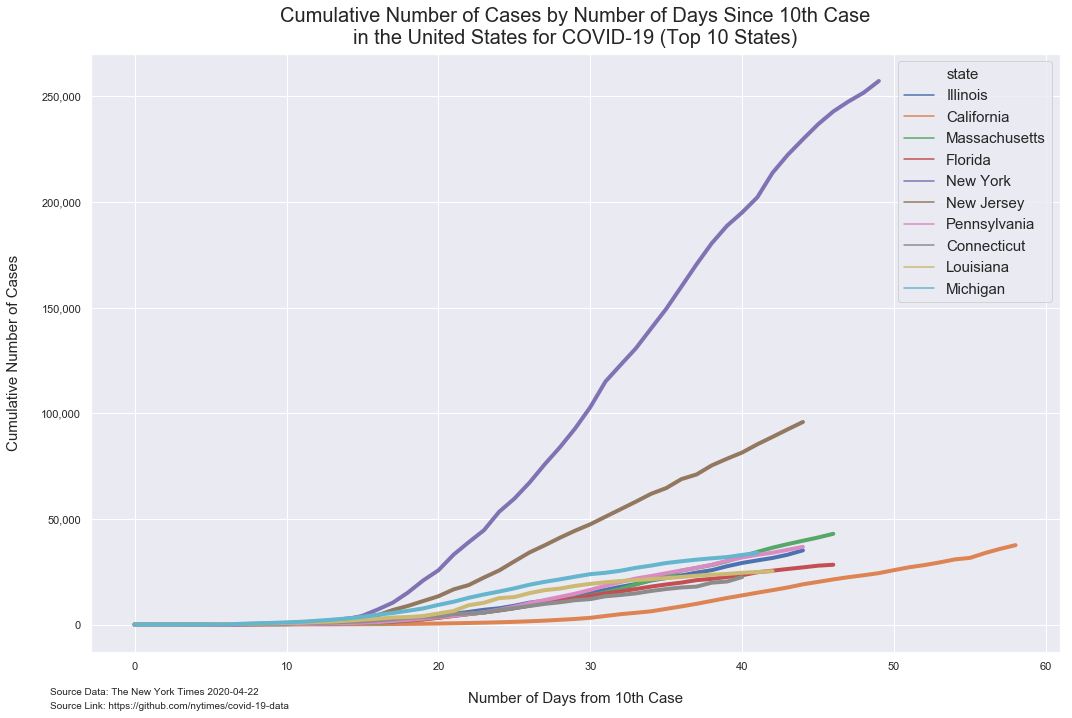

In [79]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="state",
             data=state_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-timeseries-tenth-case')

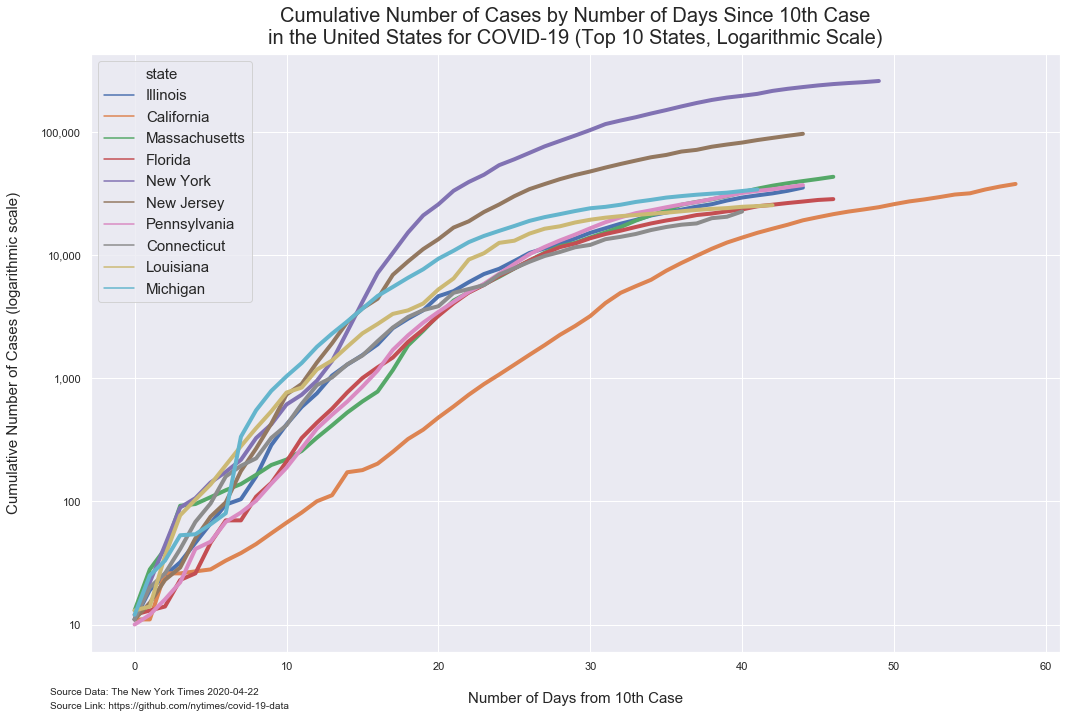

In [80]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="state",
             data=state_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [81]:
ten_cases_all_states = covid_19_state_data.loc[covid_19_state_data['cases'] >= 10]

In [82]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="state", keep = 'first').reset_index(drop=True)

In [83]:
ten_cases_all_states = ten_cases_all_states[['state', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [84]:
ten_cases_all_states

state ten_cases_date
0                   Nebraska     2020-02-17
1                      Texas     2020-02-24
2                 California     2020-02-24
3                 Washington     2020-02-29
4                   New York     2020-03-04
5                    Florida     2020-03-07
6              Massachusetts     2020-03-07
7                    Georgia     2020-03-08
8                     Oregon     2020-03-08
9               Pennsylvania     2020-03-09
10                  Illinois     2020-03-09
11                New Jersey     2020-03-09
12                  Colorado     2020-03-09
13                      Iowa     2020-03-10
14      District of Columbia     2020-03-11
15            South Carolina     2020-03-11
16                  Virginia     2020-03-11
17                   Indiana     2020-03-11
18                 Louisiana     2020-03-11
19                  Maryland     2020-03-11
20                  Kentucky     2020-03-12
21                    Nevada     2020-03-12
22                  Michigan     2020-03-12
23            North Carolina     2020-03-12
24                 Tennessee     2020-03-12
25                New Mexico     2020-03-13
26               Connecticut     2020-03-13
27                      Ohio     2020-03-13
28                 Minnesota     2020-03-13
29                 Wisconsin     2020-03-13
30              Rhode Island     2020-03-13
31                   Alabama     2020-03-14
32                   Arizona     2020-03-14
33                      Utah     2020-03-14
34               Mississippi     2020-03-15
35                     Maine     2020-03-15
36             New Hampshire     2020-03-15
37                  Arkansas     2020-03-15
38                    Hawaii     2020-03-16
39                  Oklahoma     2020-03-16
40              South Dakota     2020-03-16
41                   Wyoming     2020-03-16
42                    Kansas     2020-03-16
43                   Vermont     2020-03-16
44                  Delaware     2020-03-17
45                  Missouri     2020-03-17
46                     Idaho     2020-03-18
47                   Montana     2020-03-18
48                    Alaska     2020-03-19
49                      Guam     2020-03-19
50              North Dakota     2020-03-19
51               Puerto Rico     2020-03-20
52             West Virginia     2020-03-21
53            Virgin Islands     2020-03-22
54  Northern Mariana Islands     2020-04-08

In [85]:
ten_cases_all_states = covid_19_state_data.merge(ten_cases_all_states, left_on='state', right_on='state')

In [86]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [87]:
ten_cases_all_states

date                     state  fips  cases  deaths ten_cases_date
39   2020-02-29                Washington    53     10       1     2020-02-29
40   2020-03-01                Washington    53     17       3     2020-02-29
41   2020-03-02                Washington    53     23       6     2020-02-29
42   2020-03-03                Washington    53     32      10     2020-02-29
43   2020-03-04                Washington    53     47      11     2020-02-29
...         ...                       ...   ...    ...     ...            ...
2814 2020-04-18  Northern Mariana Islands    69     14       2     2020-04-08
2815 2020-04-19  Northern Mariana Islands    69     14       2     2020-04-08
2816 2020-04-20  Northern Mariana Islands    69     14       2     2020-04-08
2817 2020-04-21  Northern Mariana Islands    69     14       2     2020-04-08
2818 2020-04-22  Northern Mariana Islands    69     14       2     2020-04-08

[2281 rows x 6 columns]

In [88]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [89]:
ten_cases_all_states

date                     state  fips  cases  deaths ten_cases_date  \
39   2020-02-29                Washington    53     10       1     2020-02-29   
40   2020-03-01                Washington    53     17       3     2020-02-29   
41   2020-03-02                Washington    53     23       6     2020-02-29   
42   2020-03-03                Washington    53     32      10     2020-02-29   
43   2020-03-04                Washington    53     47      11     2020-02-29   
...         ...                       ...   ...    ...     ...            ...   
2814 2020-04-18  Northern Mariana Islands    69     14       2     2020-04-08   
2815 2020-04-19  Northern Mariana Islands    69     14       2     2020-04-08   
2816 2020-04-20  Northern Mariana Islands    69     14       2     2020-04-08   
2817 2020-04-21  Northern Mariana Islands    69     14       2     2020-04-08   
2818 2020-04-22  Northern Mariana Islands    69     14       2     2020-04-08   

      days_from_10_cases  
39                     0  
40                     1  
41                     2  
42                     3  
43                     4  
...                  ...  
2814                  10  
2815                  11  
2816                  12  
2817                  13  
2818                  14  

[2281 rows x 7 columns]

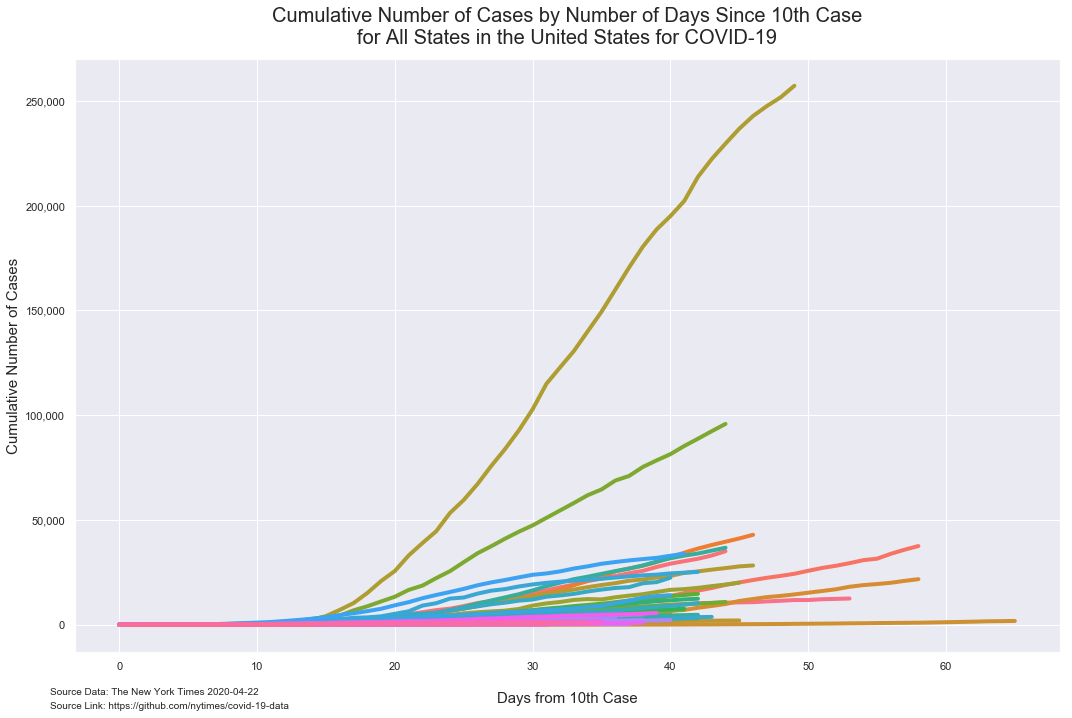

In [90]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="state",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state')

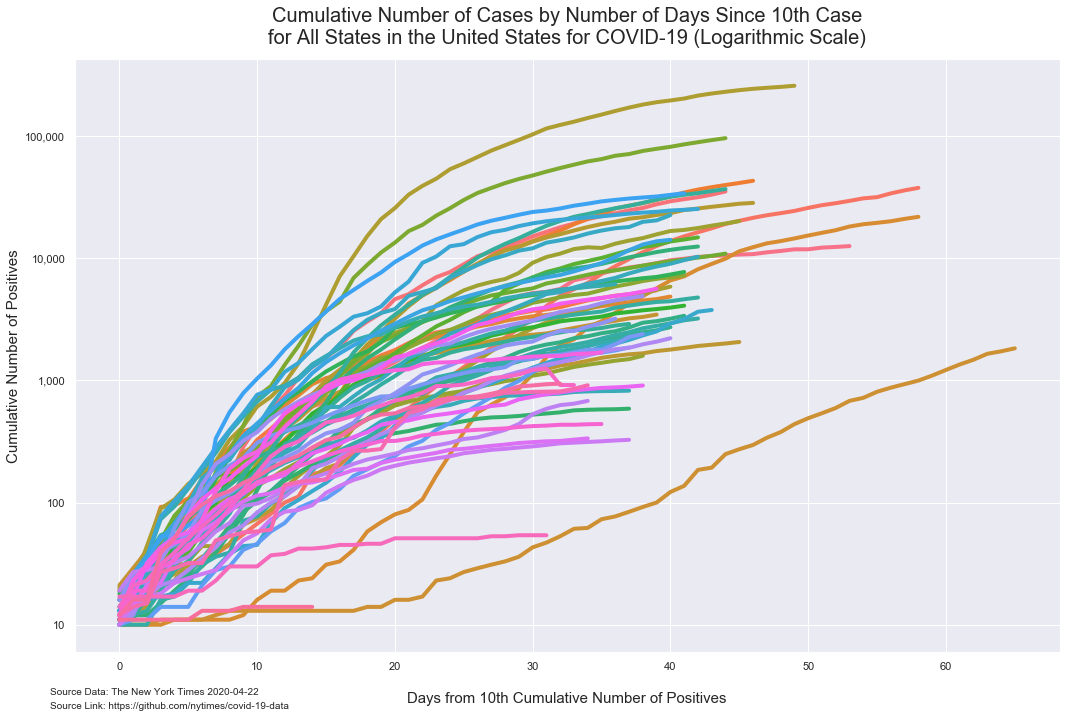

In [91]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="state",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-state-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [92]:
trajectory_plot = state_ten_cases.sort_values(by=['state', 'date','cases'], 
                                ascending=[True, True, True])

In [93]:
trajectory_plot[:50]

date       state  cases  daily_cases  deaths date_ten_case  \
120 2020-02-24  California     11          1.0       0    2020-02-24   
121 2020-02-25  California     11          0.0       0    2020-02-24   
122 2020-02-26  California     26         15.0       0    2020-02-24   
123 2020-02-27  California     26          0.0       0    2020-02-24   
124 2020-02-28  California     27          1.0       0    2020-02-24   
125 2020-02-29  California     28          1.0       0    2020-02-24   
126 2020-03-01  California     33          5.0       0    2020-02-24   
127 2020-03-02  California     38          5.0       0    2020-02-24   
128 2020-03-03  California     45          7.0       0    2020-02-24   
129 2020-03-04  California     55         10.0       1    2020-02-24   
130 2020-03-05  California     67         12.0       1    2020-02-24   
131 2020-03-06  California     81         14.0       1    2020-02-24   
132 2020-03-07  California    100         19.0       1    2020-02-24   
133 2020-03-08  California    112         12.0       1    2020-02-24   
134 2020-03-09  California    172         60.0       2    2020-02-24   
135 2020-03-10  California    179          7.0       3    2020-02-24   
136 2020-03-11  California    202         23.0       4    2020-02-24   
137 2020-03-12  California    252         50.0       4    2020-02-24   
138 2020-03-13  California    320         68.0       5    2020-02-24   
139 2020-03-14  California    381         61.0       5    2020-02-24   
140 2020-03-15  California    478         97.0       6    2020-02-24   
141 2020-03-16  California    588        110.0      11    2020-02-24   
142 2020-03-17  California    732        144.0      14    2020-02-24   
143 2020-03-18  California    893        161.0      17    2020-02-24   
144 2020-03-19  California   1067        174.0      19    2020-02-24   
145 2020-03-20  California   1283        216.0      24    2020-02-24   
146 2020-03-21  California   1544        261.0      28    2020-02-24   
147 2020-03-22  California   1851        307.0      35    2020-02-24   
148 2020-03-23  California   2240        389.0      39    2020-02-24   
149 2020-03-24  California   2644        404.0      52    2020-02-24   
150 2020-03-25  California   3183        539.0      67    2020-02-24   
151 2020-03-26  California   4060        877.0      82    2020-02-24   
152 2020-03-27  California   4914        854.0     102    2020-02-24   
153 2020-03-28  California   5565        651.0     121    2020-02-24   
154 2020-03-29  California   6266        701.0     130    2020-02-24   
155 2020-03-30  California   7421       1155.0     146    2020-02-24   
156 2020-03-31  California   8582       1161.0     183    2020-02-24   
157 2020-04-01  California   9816       1234.0     212    2020-02-24   
158 2020-04-02  California  11190       1374.0     247    2020-02-24   
159 2020-04-03  California  12569       1379.0     282    2020-02-24   
160 2020-04-04  California  13796       1227.0     323    2020-02-24   
161 2020-04-05  California  15076       1280.0     349    2020-02-24   
162 2020-04-06  California  16284       1208.0     386    2020-02-24   
163 2020-04-07  California  17540       1256.0     447    2020-02-24   
164 2020-04-08  California  19043       1503.0     506    2020-02-24   
165 2020-04-09  California  20191       1148.0     548    2020-02-24   
166 2020-04-10  California  21366       1175.0     594    2020-02-24   
167 2020-04-11  California  22421       1055.0     632    2020-02-24   
168 2020-04-12  California  23323        902.0     676    2020-02-24   
169 2020-04-13  California  24334       1011.0     725    2020-02-24   

     days_since_ten_case  
120                    0  
121                    1  
122                    2  
123                    3  
124                    4  
125                    5  
126                    6  
127                    7  
128                    8  
129                    9  
130                   10  
131          

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


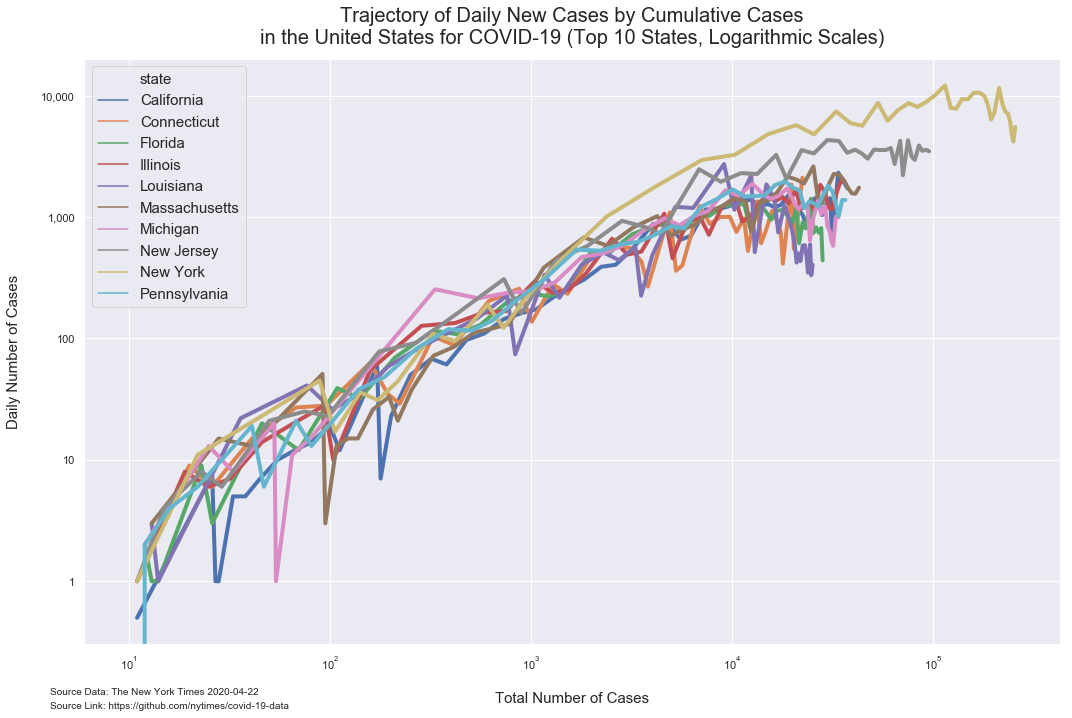

In [94]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="state",
             data=trajectory_plot, linewidth=4, ci=False)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-trajectory-daily-plot')

## Weekly

In [95]:
trajectory_plot_weekly = trajectory_plot[['state', 'date', 'cases', 'daily_cases']]

In [96]:
trajectory_plot_weekly.head()

state       date  cases  daily_cases
120  California 2020-02-24     11          1.0
121  California 2020-02-25     11          0.0
122  California 2020-02-26     26         15.0
123  California 2020-02-27     26          0.0
124  California 2020-02-28     27          1.0

In [97]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('state').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [98]:
trajectory_plot_weekly

cases  daily_cases
state        date                          
California   2020-03-01     33     3.285714
             2020-03-08    112    11.285714
             2020-03-15    478    52.285714
             2020-03-22   1851   196.142857
             2020-03-29   6266   630.714286
...                        ...          ...
Pennsylvania 2020-03-29   3441   419.571429
             2020-04-05  11589  1164.000000
             2020-04-12  22955  1623.714286
             2020-04-19  32992  1433.857143
             2020-04-26  36763  1257.000000

[75 rows x 2 columns]

In [99]:
trajectory_plot_weekly.reset_index(inplace=True)

In [100]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [101]:
trajectory_plot_weekly

state       date  cases  daily_cases_weekly_average
0     California 2020-03-01     33                    3.285714
1     California 2020-03-08    112                   11.285714
2     California 2020-03-15    478                   52.285714
3     California 2020-03-22   1851                  196.142857
4     California 2020-03-29   6266                  630.714286
..           ...        ...    ...                         ...
70  Pennsylvania 2020-03-29   3441                  419.571429
71  Pennsylvania 2020-04-05  11589                 1164.000000
72  Pennsylvania 2020-04-12  22955                 1623.714286
73  Pennsylvania 2020-04-19  32992                 1433.857143
74  Pennsylvania 2020-04-26  36763                 1257.000000

[75 rows x 4 columns]

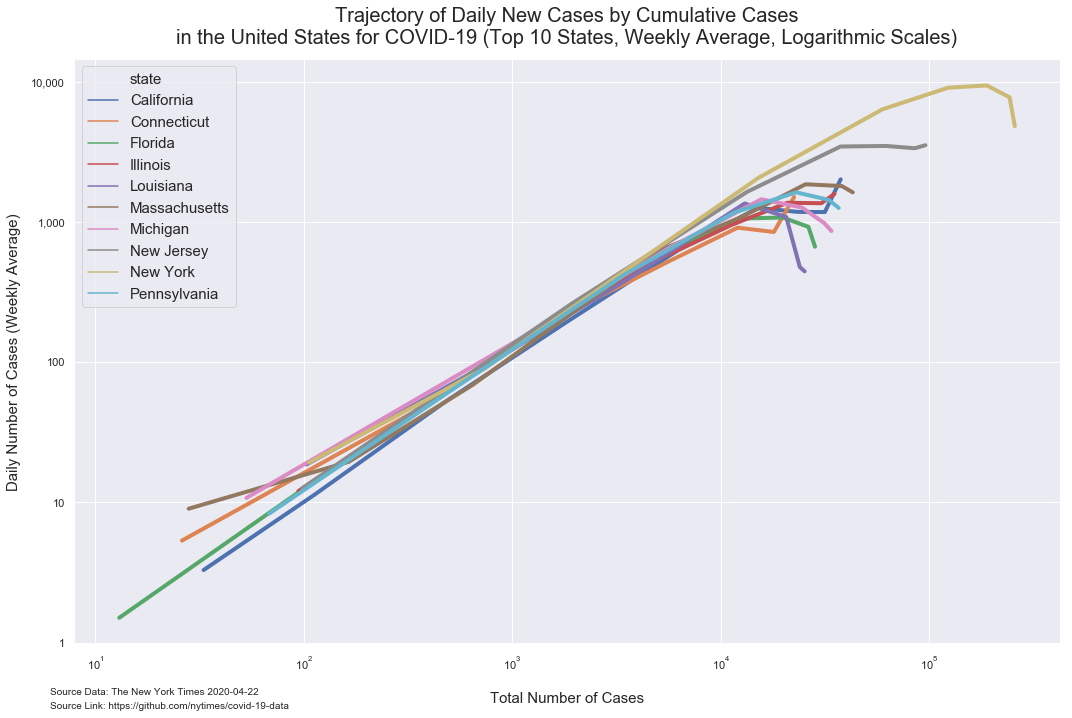

In [102]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="state",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-state-trajectory-weekly-plot')

# Trajectory for All States

In [103]:
trajectory_all_states = covid_19_state_data.sort_values(by=['state', 'date','cases'], 
                                ascending=[True, True, True])

In [104]:
trajectory_all_states

date    state  fips  cases  deaths
586  2020-03-13  Alabama     1      6       0
637  2020-03-14  Alabama     1     12       0
689  2020-03-15  Alabama     1     23       0
742  2020-03-16  Alabama     1     29       0
795  2020-03-17  Alabama     1     39       0
...         ...      ...   ...    ...     ...
2608 2020-04-18  Wyoming    56    309       2
2664 2020-04-19  Wyoming    56    313       2
2720 2020-04-20  Wyoming    56    317       2
2776 2020-04-21  Wyoming    56    322       6
2832 2020-04-22  Wyoming    56    326       6

[2833 rows x 5 columns]

In [105]:
trajectory_all_states['daily_cases'] = trajectory_all_states['cases'].diff()

In [106]:
trajectory_all_states[:50]

date    state  fips  cases  deaths  daily_cases
586  2020-03-13  Alabama     1      6       0          NaN
637  2020-03-14  Alabama     1     12       0          6.0
689  2020-03-15  Alabama     1     23       0         11.0
742  2020-03-16  Alabama     1     29       0          6.0
795  2020-03-17  Alabama     1     39       0         10.0
849  2020-03-18  Alabama     1     51       0         12.0
903  2020-03-19  Alabama     1     78       0         27.0
957  2020-03-20  Alabama     1    106       0         28.0
1011 2020-03-21  Alabama     1    131       0         25.0
1065 2020-03-22  Alabama     1    157       0         26.0
1119 2020-03-23  Alabama     1    196       0         39.0
1173 2020-03-24  Alabama     1    242       0         46.0
1227 2020-03-25  Alabama     1    386       1        144.0
1281 2020-03-26  Alabama     1    538       3        152.0
1335 2020-03-27  Alabama     1    639       4        101.0
1389 2020-03-28  Alabama     1    720       4         81.0
1444 2020-03-29  Alabama     1    830       5        110.0
1499 2020-03-30  Alabama     1    947      11        117.0
1554 2020-03-31  Alabama     1    999      13         52.0
1609 2020-04-01  Alabama     1   1106      28        107.0
1664 2020-04-02  Alabama     1   1270      32        164.0
1719 2020-04-03  Alabama     1   1535      38        265.0
1774 2020-04-04  Alabama     1   1633      44         98.0
1829 2020-04-05  Alabama     1   1841      45        208.0
1884 2020-04-06  Alabama     1   2006      53        165.0
1939 2020-04-07  Alabama     1   2197      64        191.0
1994 2020-04-08  Alabama     1   2499      67        302.0
2049 2020-04-09  Alabama     1   2838      78        339.0
2105 2020-04-10  Alabama     1   3008      80        170.0
2161 2020-04-11  Alabama     1   3262      93        254.0
2217 2020-04-12  Alabama     1   3583      93        321.0
2273 2020-04-13  Alabama     1   3805     104        222.0
2329 2020-04-14  Alabama     1   3953     114        148.0
2385 2020-04-15  Alabama     1   4241     123        288.0
2441 2020-04-16  Alabama     1   4404     137        163.0
2497 2020-04-17  Alabama     1   4572     151        168.0
2553 2020-04-18  Alabama     1   4723     147        151.0
2609 2020-04-19  Alabama     1   4903     160        180.0
2665 2020-04-20  Alabama     1   5078     164        175.0
2721 2020-04-21  Alabama     1   5327     186        249.0
2777 2020-04-22  Alabama     1   5610     201        283.0
539  2020-03-12   Alaska     2      1       0      -5609.0
587  2020-03-13   Alaska     2      1       0          0.0
638  2020-03-14   Alaska     2      1       0          0.0
690  2020-03-15   Alaska     2      1       0          0.0
743  2020-03-16   Alaska     2      3       0          2.0
796  2020-03-17   Alaska     2      6       0          3.0
850  2020-03-18   Alaska     2      9       0          3.0
904  2020-03-19   Alaska     2     12       0          3.0
958  2020-03-20   Alaska     2     14       0          2.0

In [107]:
trajectory_all_states['daily_cases'].loc[trajectory_all_states.daily_cases < 0] = trajectory_all_states.cases
trajectory_all_states['daily_cases'].loc[trajectory_all_states.daily_cases.isnull()] = trajectory_all_states.cases

In [108]:
trajectory_all_states[:50]

date    state  fips  cases  deaths  daily_cases
586  2020-03-13  Alabama     1      6       0          6.0
637  2020-03-14  Alabama     1     12       0          6.0
689  2020-03-15  Alabama     1     23       0         11.0
742  2020-03-16  Alabama     1     29       0          6.0
795  2020-03-17  Alabama     1     39       0         10.0
849  2020-03-18  Alabama     1     51       0         12.0
903  2020-03-19  Alabama     1     78       0         27.0
957  2020-03-20  Alabama     1    106       0         28.0
1011 2020-03-21  Alabama     1    131       0         25.0
1065 2020-03-22  Alabama     1    157       0         26.0
1119 2020-03-23  Alabama     1    196       0         39.0
1173 2020-03-24  Alabama     1    242       0         46.0
1227 2020-03-25  Alabama     1    386       1        144.0
1281 2020-03-26  Alabama     1    538       3        152.0
1335 2020-03-27  Alabama     1    639       4        101.0
1389 2020-03-28  Alabama     1    720       4         81.0
1444 2020-03-29  Alabama     1    830       5        110.0
1499 2020-03-30  Alabama     1    947      11        117.0
1554 2020-03-31  Alabama     1    999      13         52.0
1609 2020-04-01  Alabama     1   1106      28        107.0
1664 2020-04-02  Alabama     1   1270      32        164.0
1719 2020-04-03  Alabama     1   1535      38        265.0
1774 2020-04-04  Alabama     1   1633      44         98.0
1829 2020-04-05  Alabama     1   1841      45        208.0
1884 2020-04-06  Alabama     1   2006      53        165.0
1939 2020-04-07  Alabama     1   2197      64        191.0
1994 2020-04-08  Alabama     1   2499      67        302.0
2049 2020-04-09  Alabama     1   2838      78        339.0
2105 2020-04-10  Alabama     1   3008      80        170.0
2161 2020-04-11  Alabama     1   3262      93        254.0
2217 2020-04-12  Alabama     1   3583      93        321.0
2273 2020-04-13  Alabama     1   3805     104        222.0
2329 2020-04-14  Alabama     1   3953     114        148.0
2385 2020-04-15  Alabama     1   4241     123        288.0
2441 2020-04-16  Alabama     1   4404     137        163.0
2497 2020-04-17  Alabama     1   4572     151        168.0
2553 2020-04-18  Alabama     1   4723     147        151.0
2609 2020-04-19  Alabama     1   4903     160        180.0
2665 2020-04-20  Alabama     1   5078     164        175.0
2721 2020-04-21  Alabama     1   5327     186        249.0
2777 2020-04-22  Alabama     1   5610     201        283.0
539  2020-03-12   Alaska     2      1       0          1.0
587  2020-03-13   Alaska     2      1       0          0.0
638  2020-03-14   Alaska     2      1       0          0.0
690  2020-03-15   Alaska     2      1       0          0.0
743  2020-03-16   Alaska     2      3       0          2.0
796  2020-03-17   Alaska     2      6       0          3.0
850  2020-03-18   Alaska     2      9       0          3.0
904  2020-03-19   Alaska     2     12       0          3.0
958  2020-03-20   Alaska     2     14       0          2.0

In [109]:
trajectory_all_states = trajectory_all_states.set_index('date').groupby('state').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_states.reset_index(inplace=True)
trajectory_all_states.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [110]:
trajectory_all_states.head()

state       date  cases  daily_cases_week_avg
0  Alabama 2020-03-15     23              7.666667
1  Alabama 2020-03-22    157             19.142857
2  Alabama 2020-03-29    830             96.142857
3  Alabama 2020-04-05   1841            144.428571
4  Alabama 2020-04-12   3583            248.857143

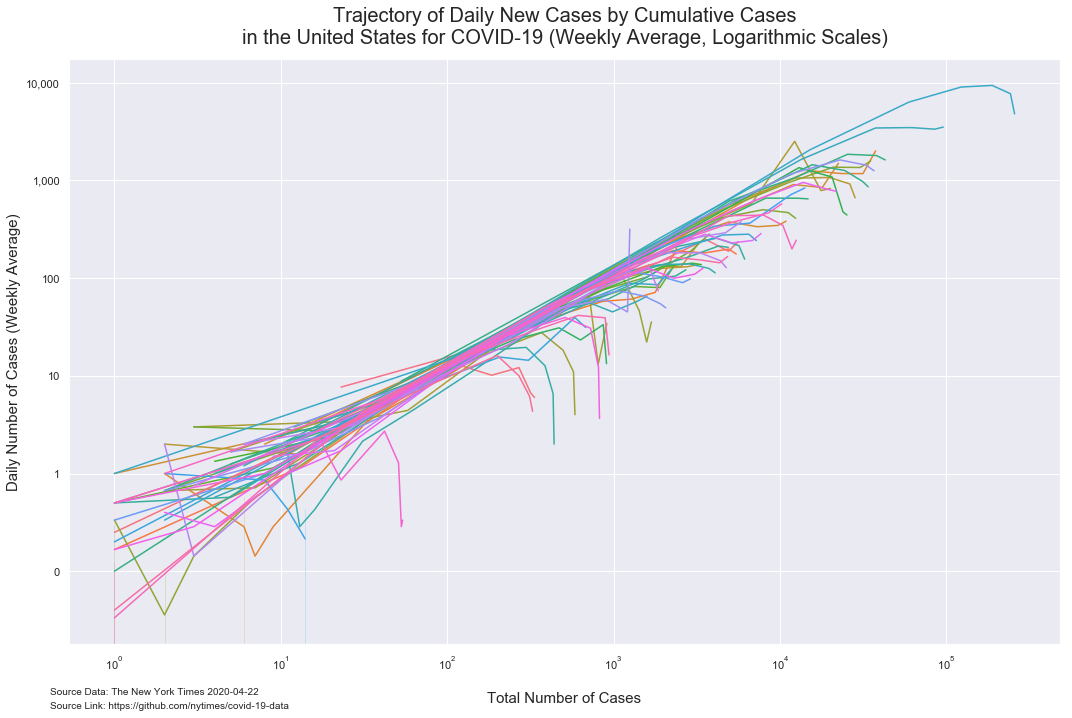

In [111]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="state",
             data=trajectory_all_states)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-all-states-trajectory-weekly-plot')

In [112]:
trajectory_all_states_scatter = trajectory_all_states.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="state", 
                                                                                        keep = 'first').reset_index(drop=True)

In [113]:
trajectory_all_states_scatter

state       date   cases  daily_cases_week_avg
0                   New York 2020-04-26  257246           4809.666667
1                 New Jersey 2020-04-26   95865           3521.333333
2              Massachusetts 2020-04-26   42944           1622.333333
3                 California 2020-04-26   37573           2009.666667
4               Pennsylvania 2020-04-26   36763           1257.000000
5                   Illinois 2020-04-26   35108           1583.666667
6                   Michigan 2020-04-26   33929            860.333333
7                    Florida 2020-04-26   28301            665.000000
8                  Louisiana 2020-04-26   25258            443.333333
9                Connecticut 2020-04-26   22469           1502.333333
10                     Texas 2020-04-26   21769            776.000000
11                   Georgia 2020-04-26   20099            826.666667
12                  Maryland 2020-04-26   14775            648.333333
13                      Ohio 2020-04-26   14117            838.333333
14                Washington 2020-04-26   12539            244.666667
15                   Indiana 2020-04-26   12438            409.333333
16                  Colorado 2020-04-26   10878            382.666667
17                  Virginia 2020-04-26   10266            576.333333
18                 Tennessee 2020-04-26    7704            286.333333
19            North Carolina 2020-04-26    7220            242.333333
20                  Missouri 2020-04-26    6137            156.666667
21              Rhode Island 2020-04-26    5841            378.333333
22                   Alabama 2020-04-26    5610            235.666667
23                   Arizona 2020-04-26    5459            176.666667
24               Mississippi 2020-04-26    4894            206.666667
25                 Wisconsin 2020-04-26    4845            166.333333
26            South Carolina 2020-04-26    4761            128.000000
27                    Nevada 2020-04-26    4081            113.333333
28                      Iowa 2020-04-26    3764            283.000000
29                      Utah 2020-04-26    3451            126.666667
30                  Kentucky 2020-04-26    3373            137.666667
31      District of Columbia 2020-04-26    3206            137.666667
32                  Delaware 2020-04-26    3200            220.666667
33                  Oklahoma 2020-04-26    2894             98.333333
34                 Minnesota 2020-04-26    2721            121.666667
35                  Arkansas 2020-04-26    2392            203.666667
36                    Kansas 2020-04-26    2292            131.333333
37                New Mexico 2020-04-26    2210            121.666667
38                    Oregon 2020-04-26    2059             49.666667
39              South Dakota 2020-04-26    1858             74.333333
40                  Nebraska 2020-04-26    1827            117.666667
41                     Idaho 2020-04-26    1688             35.666667
42             New Hampshire 2020-04-26    1588             65.333333
43               Puerto Rico 2020-04-26    1252            318.000000
44             West Virginia 2020-04-26     939             16.333333
45                      Guam 2020-04-26     911             34.333333
46                     Maine 2020-04-26     907             13.333333
47                   Vermont 2020-04-26     823              3.666667
48              North Dakota 2020-04-26     679             31.333333
49                    Hawaii 2020-04-26     586              4.000000
50                   Montana 2020-04-26     439              2.000000
51                    Alaska 2020-04-26     335              6.000000
52                   Wyoming 2020-04-26     326              4.333333
53            Virgin Islands 2020-04-26      54              0.333333
54  Northern Mariana Islands 2020-04-26      14              0.000000
55            American Samoa 2020-04-26       0              0.000000

In [114]:
len(trajectory_all_states_scatter)

56

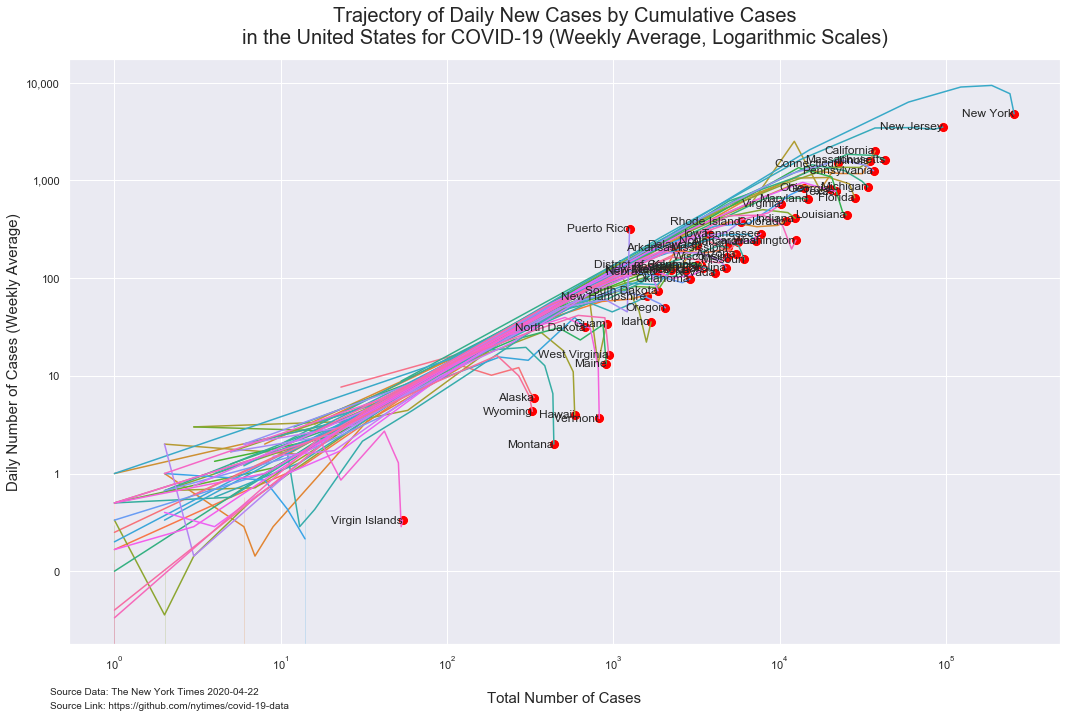

In [115]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="state",
             data=trajectory_all_states)

sns.scatterplot(x="cases", y="daily_cases_week_avg", 
             data=trajectory_all_states_scatter, s=100, ax=ax1, color='red')


x = trajectory_all_states_scatter.daily_cases_week_avg
z = trajectory_all_states_scatter.cases
n = trajectory_all_states_scatter.state
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
#ax1.set_xbound(lower=100)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-all-states-trajectory-weekly-plot-labels')

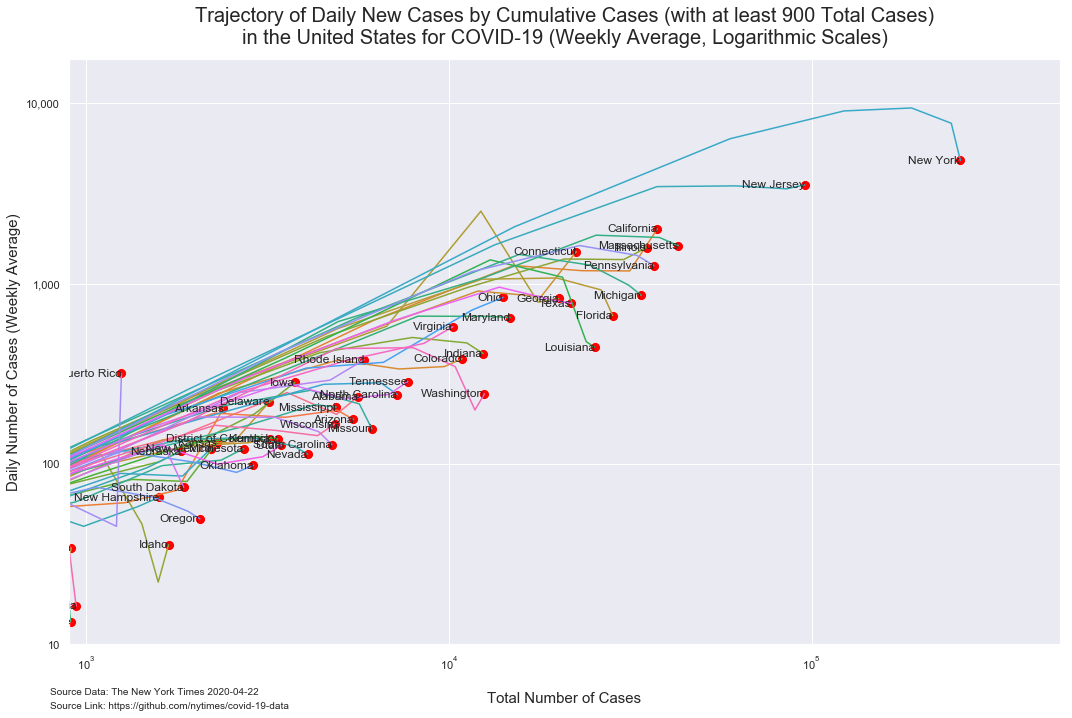

In [116]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="state",
             data=trajectory_all_states)

sns.scatterplot(x="cases", y="daily_cases_week_avg", 
             data=trajectory_all_states_scatter, s=100, ax=ax1, color='red')


x = trajectory_all_states_scatter.daily_cases_week_avg
z = trajectory_all_states_scatter.cases
n = trajectory_all_states_scatter.state
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

plt.xlim(900)
plt.ylim(10)


ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases (with at least 900 Total Cases)\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-all-states-trajectory-weekly-plot-labels-xlimit')

# Timeseries for USA

In [117]:
g = covid_19_state_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [118]:
g.index.dtype

dtype('<M8[ns]')

In [119]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [120]:
g.tail()

date   cases
date                         
2020-04-18 2020-04-18  728094
2020-04-19 2020-04-19  753314
2020-04-20 2020-04-20  780449
2020-04-21 2020-04-21  805771
2020-04-22 2020-04-22  834340

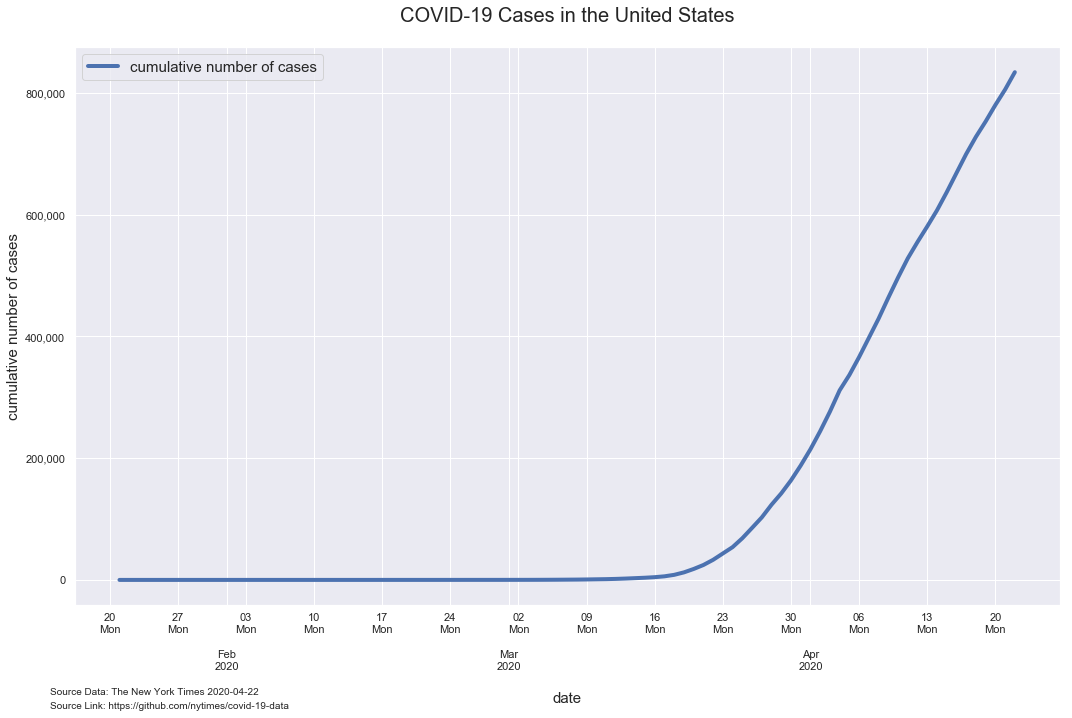

In [121]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-linear')

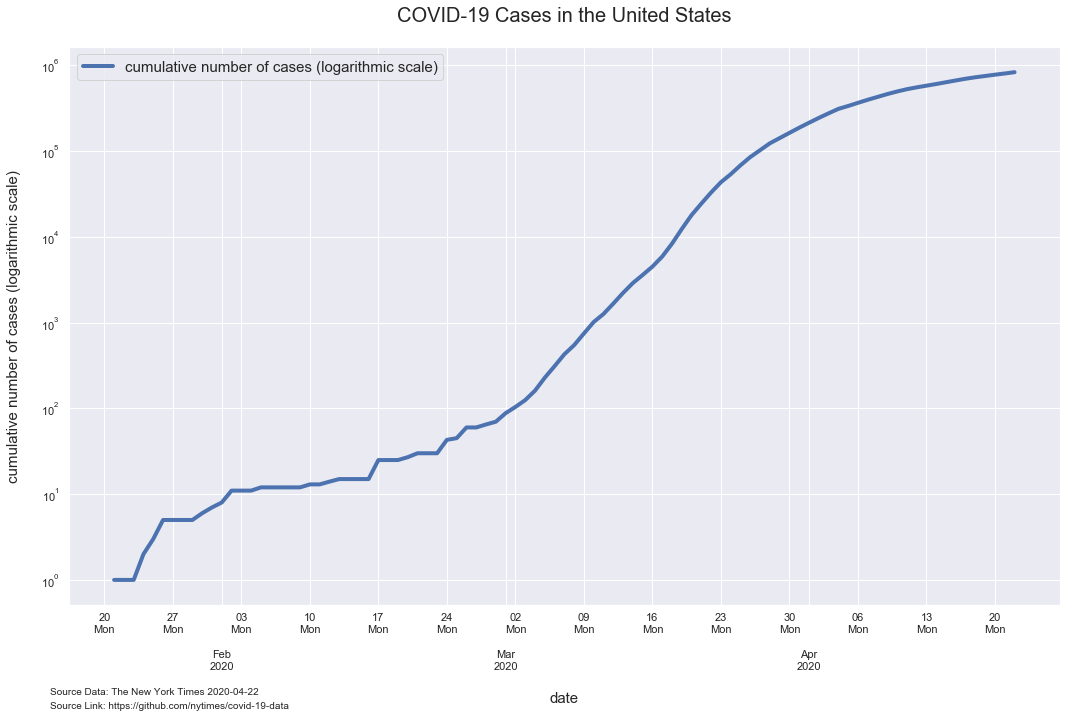

In [122]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-log')

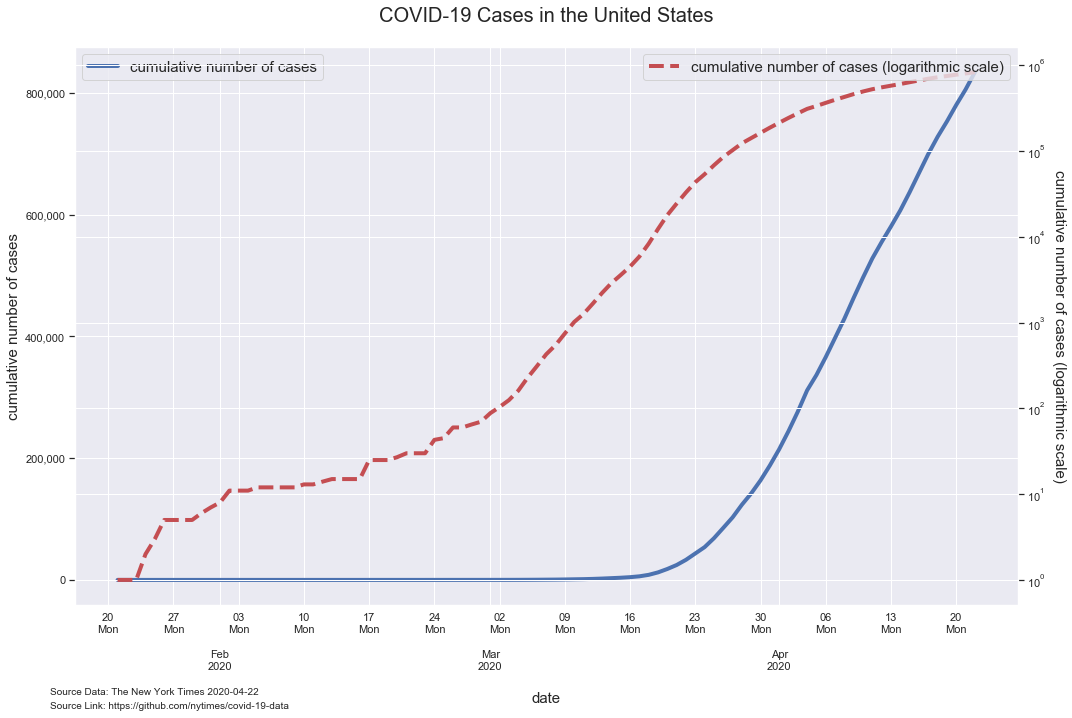

In [123]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-overlay')

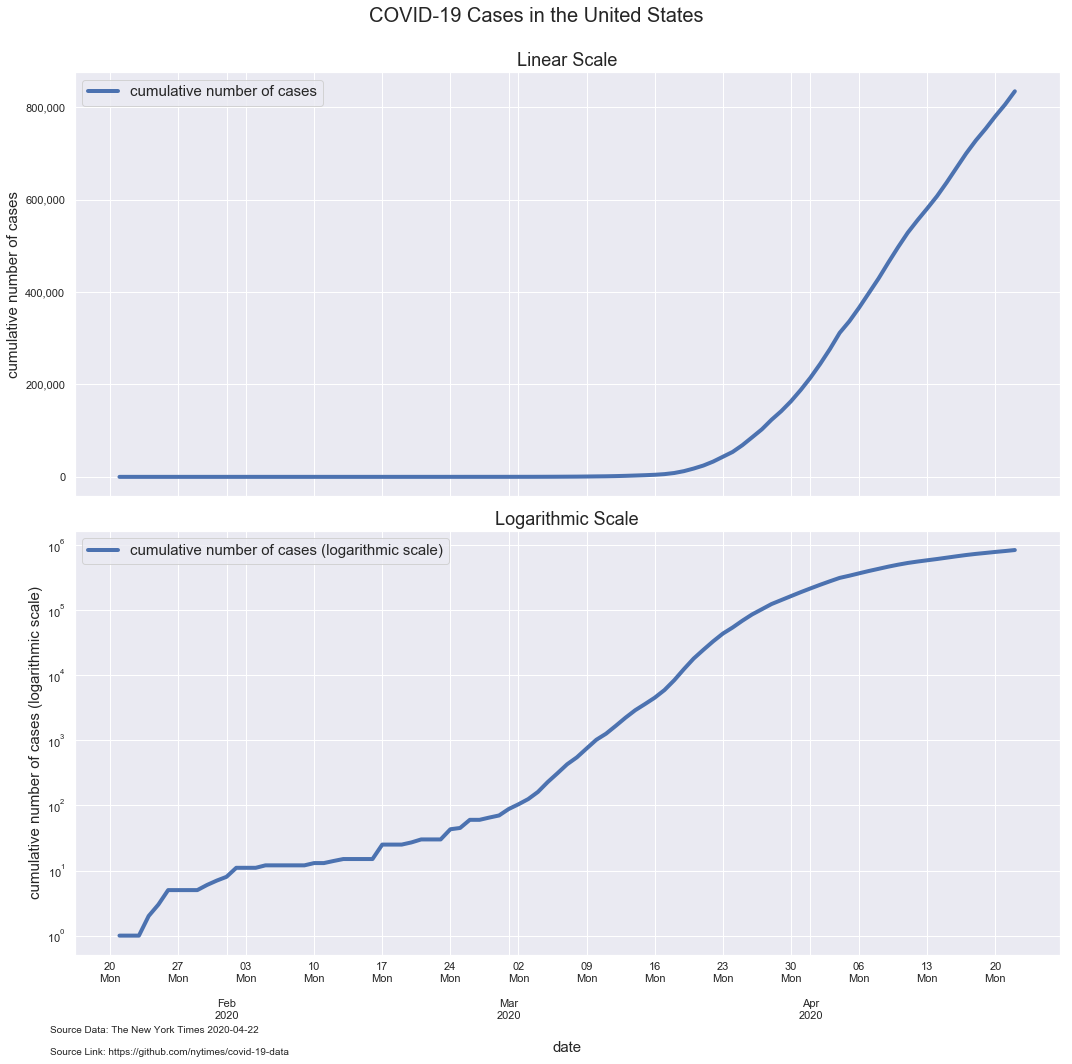

In [124]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/nyt-covid-19-data-2-subplots')

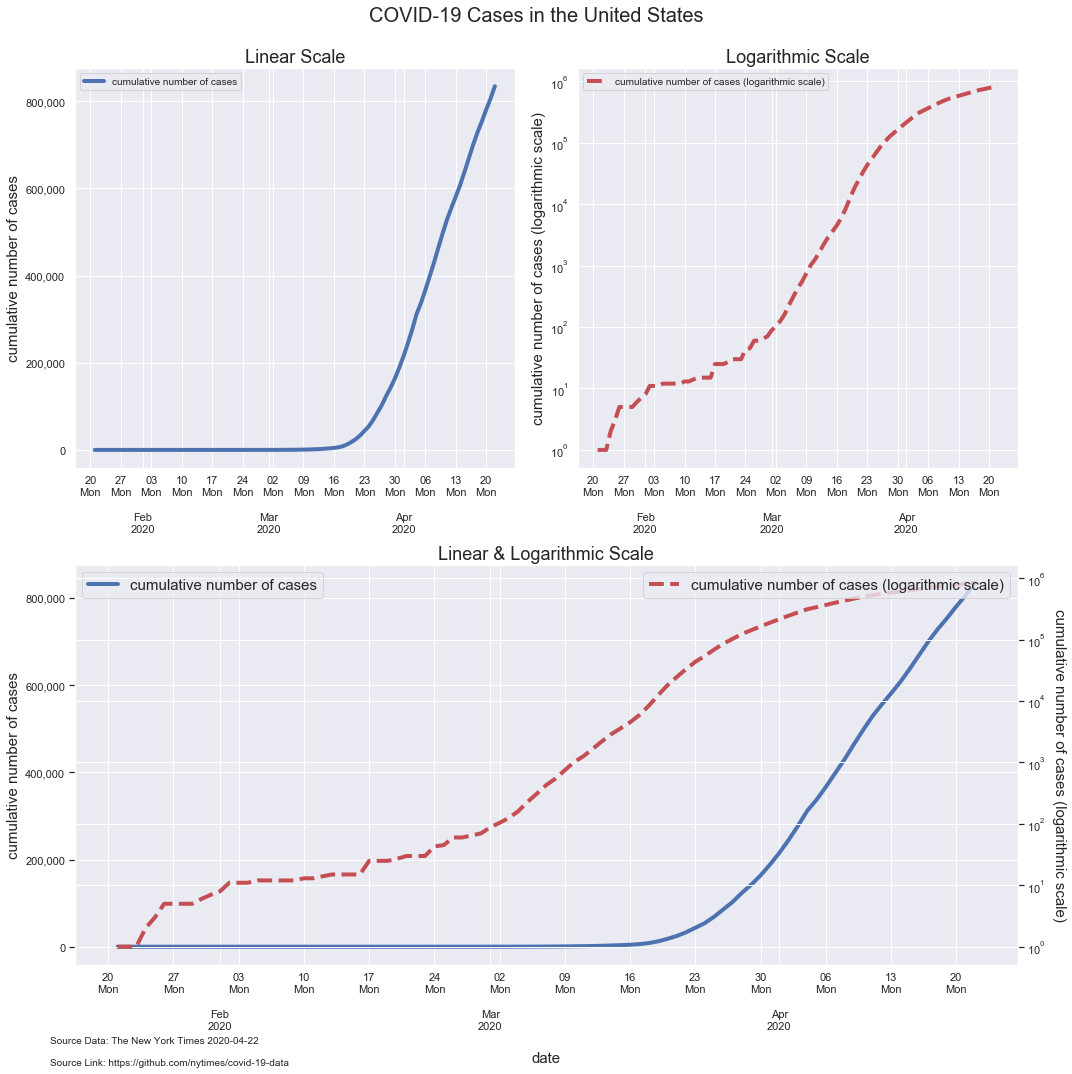

In [125]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-3-subplots')

# Country Trajectory Plot

In [126]:
g['daily_cases'] = g['cases'].diff()

In [127]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [128]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [129]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     88         18.0
2020-03-02 2020-03-02    104         16.0
2020-03-03 2020-03-03    125         21.0
2020-03-04 2020-03-04    161         36.0
2020-03-05 2020-03-05    228         67.0
2020-03-06 2020-03-06    311         83.0
2020-03-07 2020-03-07    428        117.0
2020-03-08 2020-03-08    547        119.0
2020-03-09 2020-03-09    748        201.0
2020-03-10 2020-03-10   1018        270.0

In [130]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [131]:
g_weekly

cases   daily_cases
date                            
2020-01-26       5      0.833333
2020-02-02      11      0.857143
2020-02-09      12      0.142857
2020-02-16      15      0.428571
2020-02-23      30      2.142857
2020-03-01      88      8.285714
2020-03-08     547     65.571429
2020-03-15    3600    436.142857
2020-03-22   33043   4206.142857
2020-03-29  142194  15593.000000
2020-04-05  336771  27796.714286
2020-04-12  555327  31222.285714
2020-04-19  753314  28283.857143
2020-04-26  834340  27008.666667

In [132]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [133]:
g_weekly

date   cases   daily_cases
0  2020-01-26       5      0.833333
1  2020-02-02      11      0.857143
2  2020-02-09      12      0.142857
3  2020-02-16      15      0.428571
4  2020-02-23      30      2.142857
5  2020-03-01      88      8.285714
6  2020-03-08     547     65.571429
7  2020-03-15    3600    436.142857
8  2020-03-22   33043   4206.142857
9  2020-03-29  142194  15593.000000
10 2020-04-05  336771  27796.714286
11 2020-04-12  555327  31222.285714
12 2020-04-19  753314  28283.857143
13 2020-04-26  834340  27008.666667

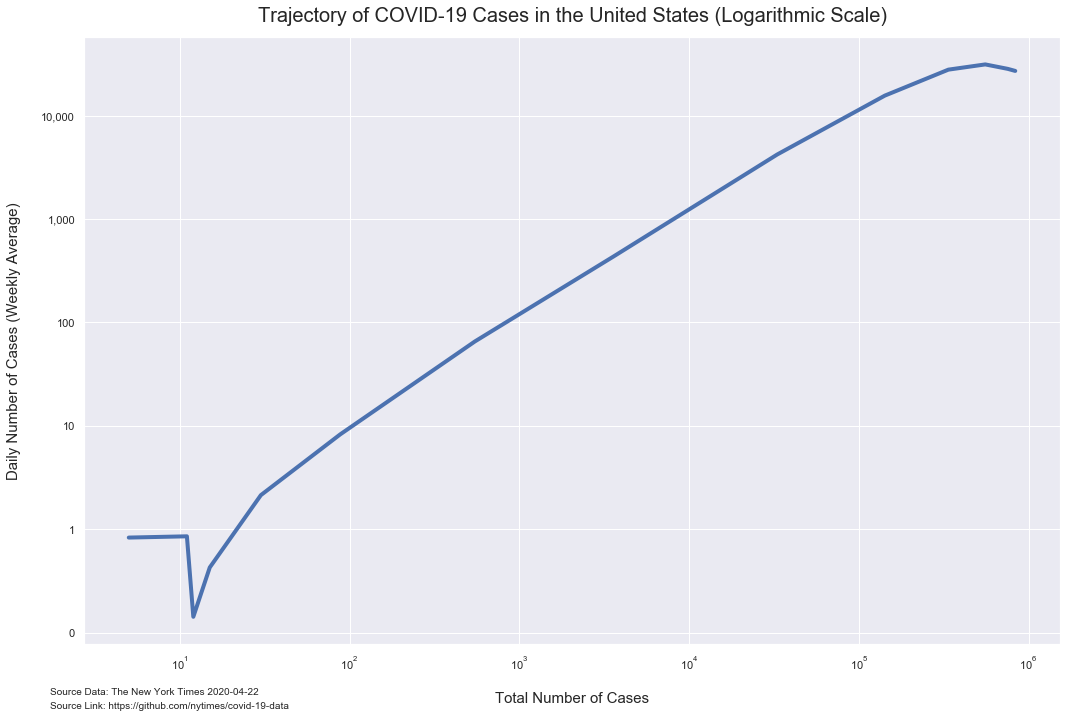

In [134]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/nyt-covid-19-usa-trajectory-weekly-plot')

# Bar Chart

In [135]:
covid_19_state_data

date          state  fips  cases  deaths
0    2020-01-21     Washington    53      1       0
1    2020-01-22     Washington    53      1       0
2    2020-01-23     Washington    53      1       0
3    2020-01-24       Illinois    17      1       0
4    2020-01-24     Washington    53      1       0
...         ...            ...   ...    ...     ...
2828 2020-04-22       Virginia    51  10266     349
2829 2020-04-22     Washington    53  12539     696
2830 2020-04-22  West Virginia    54    939      29
2831 2020-04-22      Wisconsin    55   4845     247
2832 2020-04-22        Wyoming    56    326       6

[2833 rows x 5 columns]

In [136]:
# dropping ALL duplicate values 
state_current_cases = covid_19_state_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="state", keep = 'first')

In [137]:
state_current_cases.head()

date          state  fips  cases  deaths
2832 2020-04-22        Wyoming    56    326       6
2804 2020-04-22       Missouri    29   6137     236
2802 2020-04-22      Minnesota    27   2721     179
2801 2020-04-22       Michigan    26  33929    2812
2800 2020-04-22  Massachusetts    25  42944    2182

In [138]:
state_current_cases.state.value_counts()

Pennsylvania                1
Kansas                      1
Virgin Islands              1
Missouri                    1
West Virginia               1
Minnesota                   1
Oregon                      1
Maine                       1
Wisconsin                   1
North Carolina              1
Idaho                       1
Wyoming                     1
Northern Mariana Islands    1
New York                    1
New Mexico                  1
Louisiana                   1
Mississippi                 1
Oklahoma                    1
Utah                        1
Alabama                     1
District of Columbia        1
Puerto Rico                 1
Hawaii                      1
California                  1
New Hampshire               1
North Dakota                1
Washington                  1
Alaska                      1
South Dakota                1
Vermont                     1
New Jersey                  1
Maryland                    1
Arkansas                    1
Michigan  

In [139]:
state_current_cases.loc[state_current_cases.state == 'New York']

date     state  fips   cases  deaths
2811 2020-04-22  New York    36  257246   15302

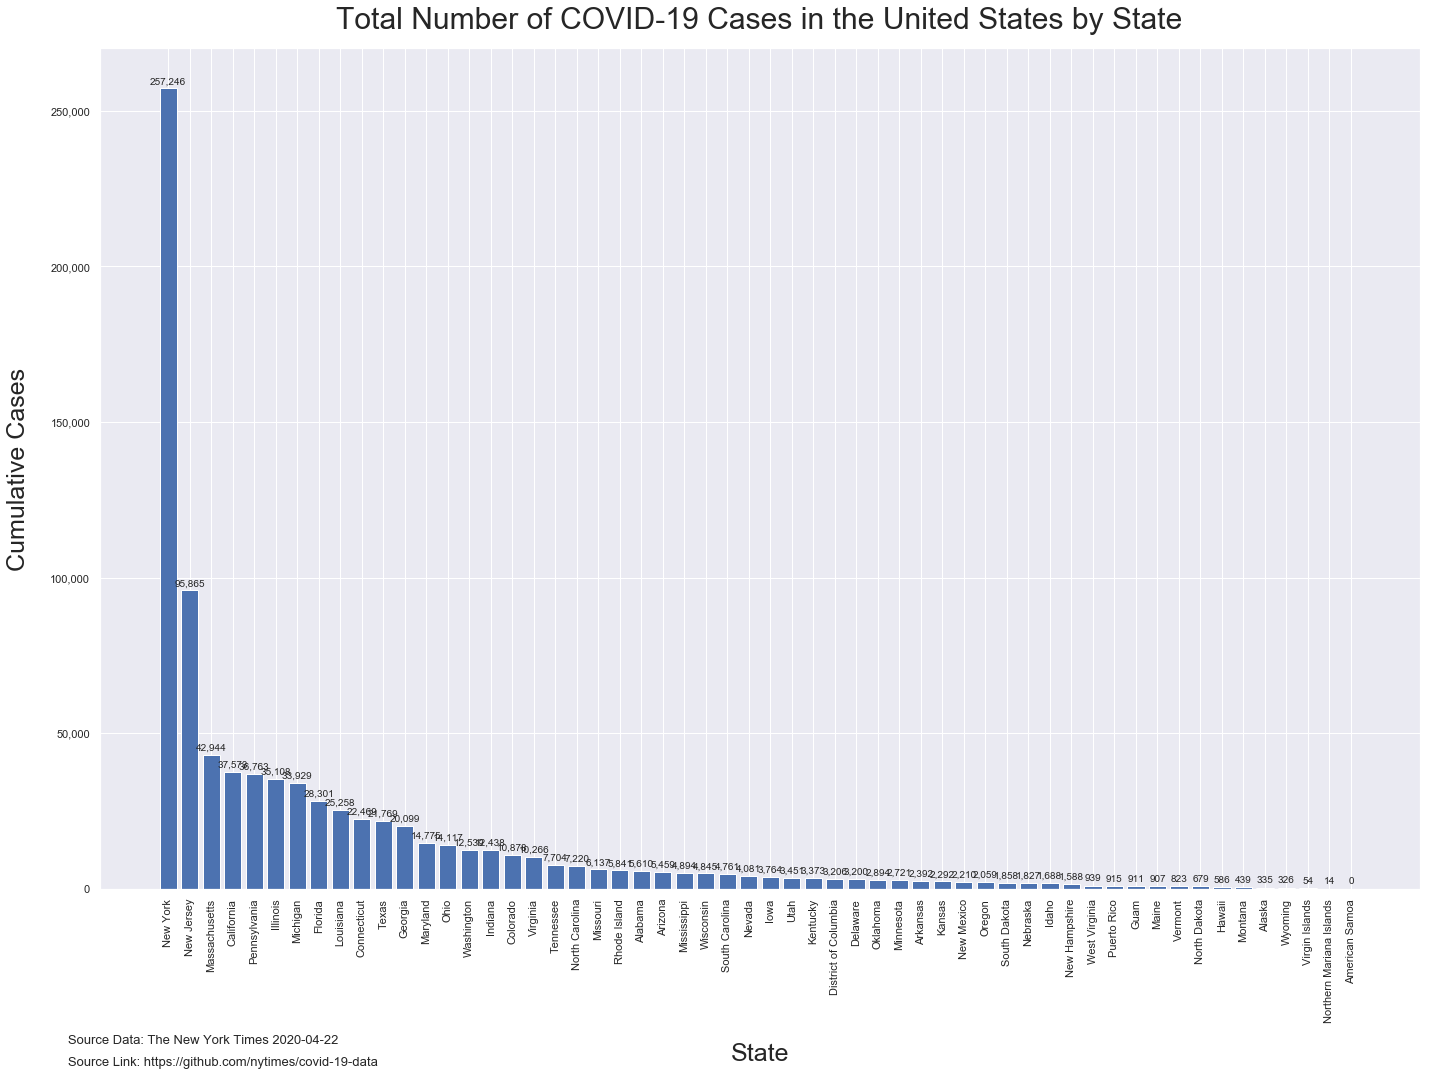

In [140]:
bar = state_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar.set_index('state', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("State", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by State", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-bar')

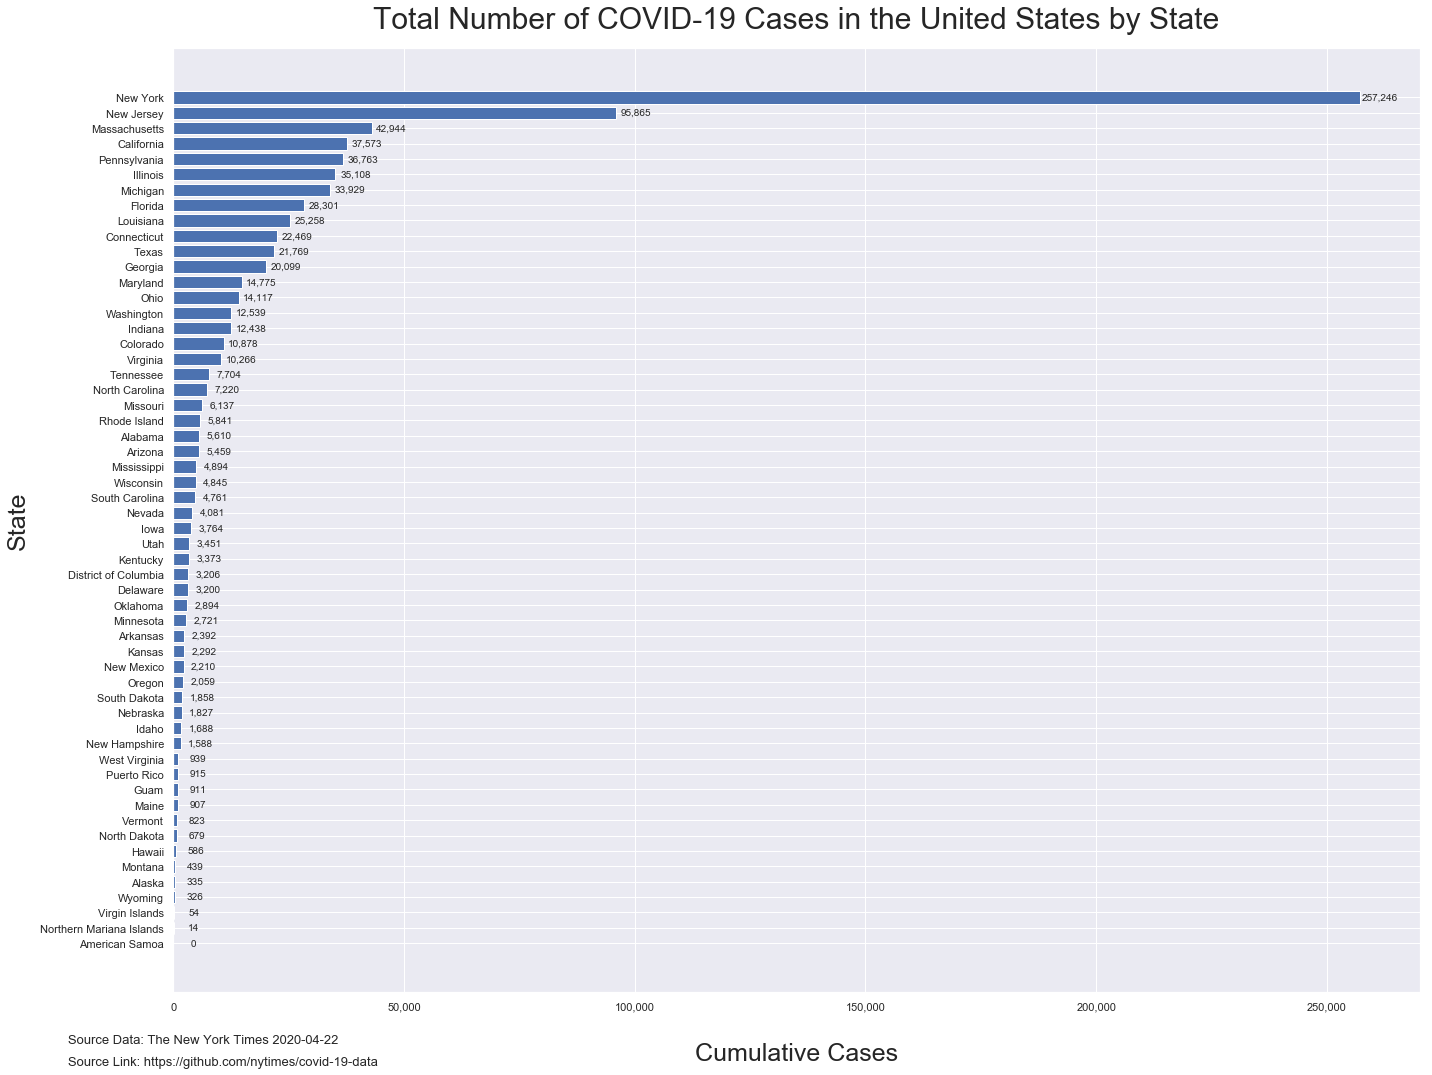

In [141]:
bar = state_current_cases.sort_values(by = 'cases', 
                    ascending=True)
bar.set_index('state', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("State", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by State", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-barh')

# I have downloaded the shapefile already

In [142]:
#url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

# data_path = 'data'
# fullfilename = os.path.join(data_path, 'state_shape.gz')
# urllib.request.urlretrieve(url, fullfilename)

In [143]:
#file_path = 'data/state_shape.gz'

# items = zipfile.ZipFile(file_path)

# available files in the container
# print(items.namelist())

In [144]:
# opening Zip using 'with' keyword in read mode
# with zipfile.ZipFile(file_path, 'r') as file:
#     file.extractall(data_path)

In [145]:
states_shape = gpd.GeoDataFrame.from_file('data/cb_2018_us_state_500k.shp')

In [146]:
states_shape.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  (POLYGON ((-88.502966 30.215235, -88.491759 30...  
1  (POLYGON ((-75.72680699999999 35.935844, -75.7...  
2  POLYGON ((-103.002565 36.526588, -103.002188 3...  
3  (POLYGON ((-75.742406 37.80835, -75.741512 37....  
4  POLYGON ((-82.6431981036679 38.1690897960737, ...

In [147]:
states_shape.sort_values(by='NAME')

STATEFP   STATENS     AFFGEOID GEOID STUSPS  \
17      01  01779775  0400000US01    01     AL   
27      02  01785533  0400000US02    02     AK   
37      60  01802701  0400000US60    60     AS   
35      04  01779777  0400000US04    04     AZ   
52      05  00068085  0400000US05    05     AR   
16      06  01779778  0400000US06    06     CA   
21      08  01779779  0400000US08    08     CO   
45      69  01779809  0400000US69    69     MP   
55      09  01779780  0400000US09    09     CT   
43      10  01779781  0400000US10    10     DE   
36      11  01702382  0400000US11    11     DC   
9       12  00294478  0400000US12    12     FL   
18      13  01705317  0400000US13    13     GA   
44      66  01802705  0400000US66    66     GU   
42      15  01779782  0400000US15    15     HI   
8       16  01779783  0400000US16    16     ID   
29      17  01779784  0400000US17    17     IL   
53      18  00448508  0400000US18    18     IN   
32      19  01779785  0400000US19    19     IA   
26      20  00481813  0400000US20    20     KS   
47      21  01779786  0400000US21    21     KY   
5       22  01629543  0400000US22    22     LA   
41      23  01779787  0400000US23    23     ME   
40      24  01714934  0400000US24    24     MD   
7       25  00606926  0400000US25    25     MA   
6       26  01779789  0400000US26    26     MI   
54      27  00662849  0400000US27    27     MN   
0       28  01779790  0400000US28    28     MS   
20      29  01779791  0400000US29    29     MO   
31      30  00767982  0400000US30    30     MT   
10      31  01779792  0400000US31    31     NE   
28      32  01779793  0400000US32    32     NV   
34      33  01779794  0400000US33    33     NH   
39      34  01779795  0400000US34    34     NJ   
12      35  00897535  0400000US35    35     NM   
25      36  01779796  0400000US36    36     NY   
1       37  01027616  0400000US37    37     NC   
51      38  01779797  0400000US38    38     ND   
48      39  01085497  0400000US39    39     OH   
2       40  01102857  0400000US40    40     OK   
50      41  01155107  0400000US41    41     OR   
19      42  01779798  0400000US42    42     PA   
13      72  01779808  0400000US72    72     PR   
46      44  01219835  0400000US44    44     RI   
33      45  01779799  0400000US45    45     SC   
14      46  01785534  0400000US46    46     SD   
23      47  01325873  0400000US47    47     TN   
15      48  01779801  0400000US48    48     TX   
38      78  01802710  0400000US78    78     VI   
22      49  01455989  0400000US49    49     UT   
30      50  01779802  0400000US50    50     VT   
3       51  01779803  0400000US51    51     VA   
11      53  01779804  0400000US53    53     WA   
4       54  01779805  0400000US54    54     WV   
49      55  01779806  0400000US55    55     WI   
24      56  01779807  0400000US56    56     WY   

                                            NAME LSAD          ALAND  \
17                                       Alabama   00   131174048583   
27                                        Alaska   00  1478839695958   
37                                American Samoa   00      197759063   
35                                       Arizona   00   294198551143   
52                                      Arkansas   00   134768872727   
16                                    California   00   403503931312   
21                                      Colorado   00   268422891711   
45  Commonwealth of the Northern Mariana Islands   00      472292529   
55                                   Connecticut   00    12542497068   
43                                      Delaware   00     5045925646   
36                          District of Columbia   00      158340391   
9                                        Florida   00   138949136250   
18                                       Georgia   00   149482048342   
44                                          Guam   00      543555840   
42                                        Hawaii   00    16633990195   


In [148]:
bar_drop_index = bar.reset_index(drop=True)

states_shape_cases = states_shape.merge(bar_drop_index, left_on='NAME', right_on='state')

In [149]:
states_shape_cases.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry       date  \
0  (POLYGON ((-88.502966 30.215235, -88.491759 30... 2020-04-22   
1  (POLYGON ((-75.72680699999999 35.935844, -75.7... 2020-04-22   
2  POLYGON ((-103.002565 36.526588, -103.002188 3... 2020-04-22   
3  (POLYGON ((-75.742406 37.80835, -75.741512 37.... 2020-04-22   
4  POLYGON ((-82.6431981036679 38.1690897960737, ... 2020-04-22   

            state  fips  cases  deaths  
0     Mississippi    28   4894     193  
1  North Carolina    37   7220     242  
2        Oklahoma    40   2894     169  
3        Virginia    51  10266     349  
4   West Virginia    54    939      29

In [150]:
states_shape_cases.STUSPS.unique()

array(['MS', 'NC', 'OK', 'VA', 'WV', 'LA', 'MI', 'MA', 'ID', 'FL', 'NE',
       'WA', 'NM', 'PR', 'SD', 'TX', 'CA', 'AL', 'GA', 'PA', 'MO', 'CO',
       'UT', 'TN', 'WY', 'NY', 'KS', 'AK', 'NV', 'IL', 'VT', 'MT', 'IA',
       'SC', 'NH', 'AZ', 'DC', 'AS', 'NJ', 'MD', 'ME', 'HI', 'DE', 'GU',
       'RI', 'KY', 'OH', 'WI', 'OR', 'ND', 'AR', 'IN', 'MN', 'CT'],
      dtype=object)

(-2259318.989842429,
 2743787.7776512564,
 -2259441.9737315555,
 874818.5571526419)

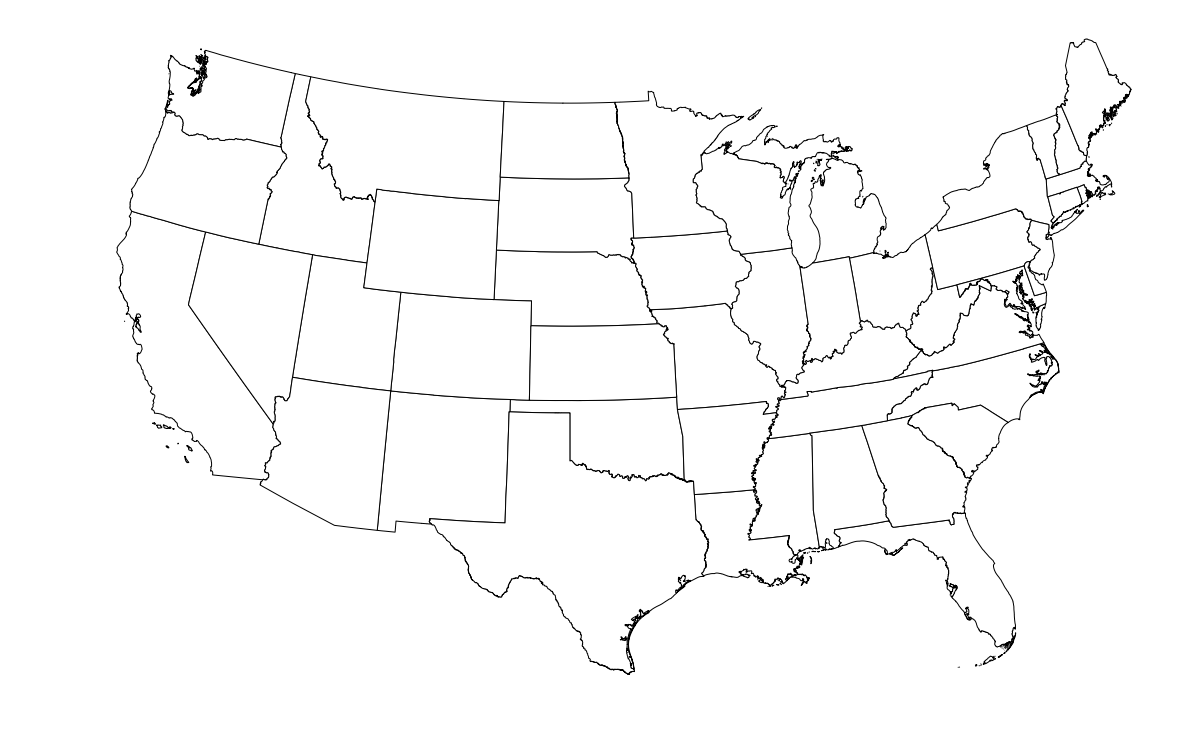

In [151]:
fig, ax = plt.subplots(figsize=(20,15))

delete_states = ['AK', 'AS', 'HI', 'PR', 'GU']
states_shape_cases  = states_shape_cases.loc[~states_shape_cases['STUSPS'].isin(delete_states)]
states_shape_cases = states_shape_cases.to_crs(epsg=2163)

states_shape_cases.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [152]:
states_shape_cases['point'] = states_shape_cases['geometry'].centroid
state_points = states_shape_cases[['point', 'NAME', 'cases']]
state_points = state_points.set_geometry('point')
state_points['coords'] = state_points['point'].apply(lambda x: x.representative_point().coords[:])
state_points['coords'] = [state_points[0] for state_points in state_points['coords']]

In [153]:
state_points.head()

point            NAME  cases  \
0  POINT (968900.5142401541 -1302349.006773153)     Mississippi   4894   
1  POINT (1849270.427707764 -820703.8884651705)  North Carolina   7220   
2  POINT (227351.7828779383 -1041651.468761091)        Oklahoma   2894   
3  POINT (1846721.444074068 -594717.0352157739)        Virginia  10266   
4  POINT (1666480.709214782 -511066.3749840383)   West Virginia    939   

                                     coords  
0  (968900.5142401541, -1302349.0067731533)  
1  (1849270.4277077643, -820703.8884651705)  
2  (227351.7828779383, -1041651.4687610908)  
3  (1846721.4440740685, -594717.0352157739)  
4   (1666480.709214782, -511066.3749840383)

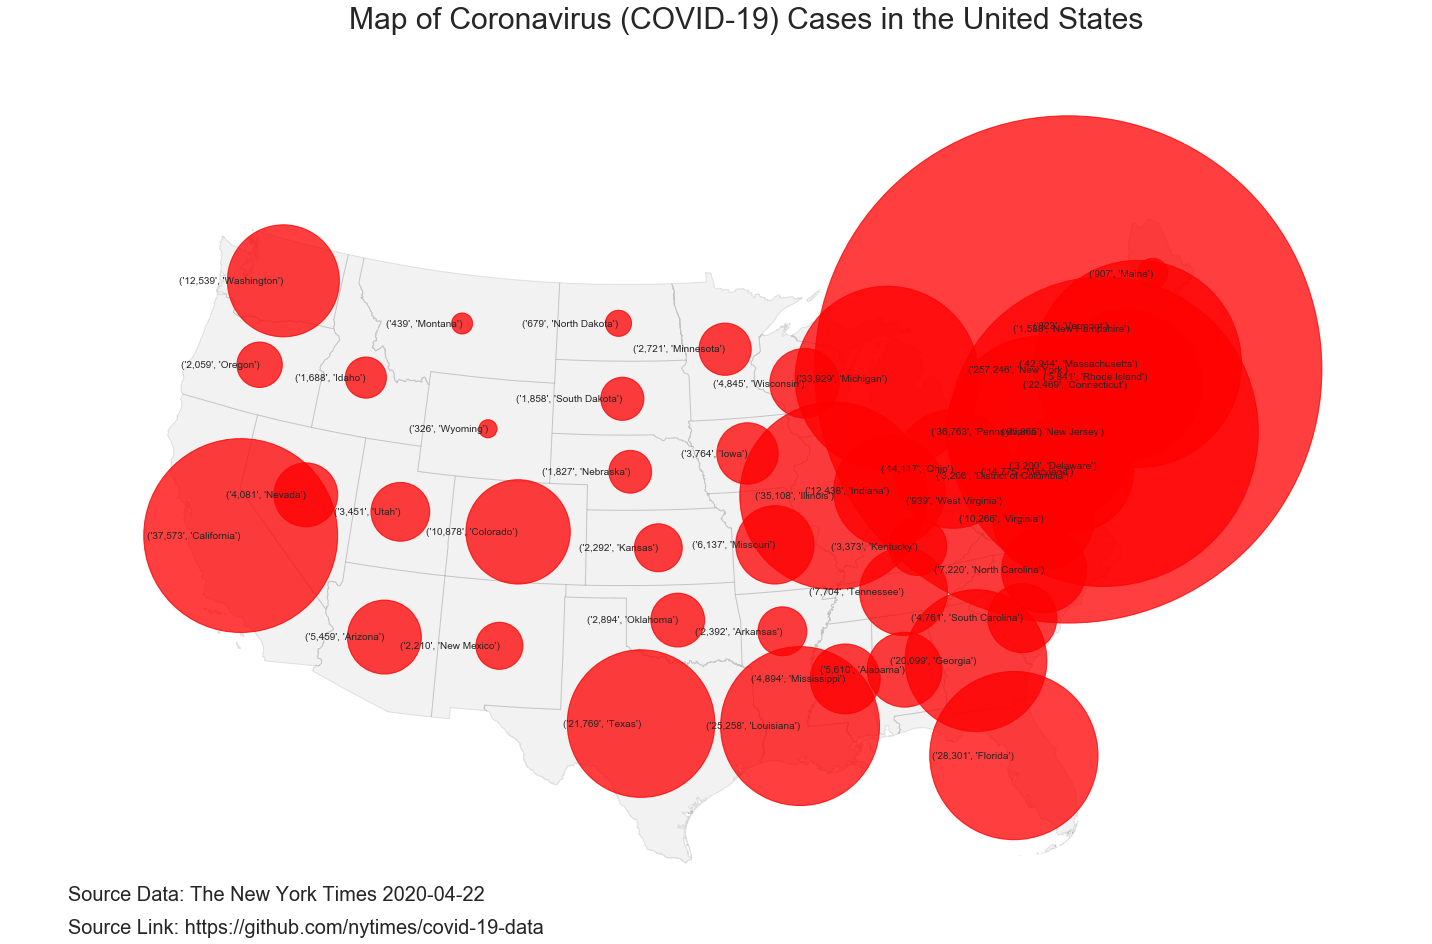

In [154]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape_cases.plot(ax=ax, color='gray', edgecolor='black', alpha=.1)
state_points.plot(ax=ax, color='red', markersize=state_points['cases'], alpha=.5)

state_points.plot(ax=ax, color='red', markersize=state_points['cases'], alpha=.5)
for idx, row in state_points.iterrows():
    plt.annotate(s=('{:,}'.format(row['cases']), row['NAME']), xy=row['coords'],
                 horizontalalignment='right', va='center')
    
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.1, txt, wrap=True, horizontalalignment='left', fontsize=20)
plt.figtext(0.05, 0.07, txt2, wrap=True, horizontalalignment='left', fontsize=20)

ax.set_title('Map of Coronavirus (COVID-19) Cases in the United States', fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/nyt-covid-19-data-state-map')

In [155]:
# # defining our plot
# plt.subplots(figsize=(20,15))
# ax = plt.subplot()

# fig = states_shape_cases.plot(column=("cases"), ax=ax, k=7, 
#                    scheme='fisher_jenks', label=True, legend=True, 
#                    legend_kwds={'loc': 'lower left', 'title': 'Number of COVID-19 Cases', 
#                    'title_fontsize': 'x-large','fontsize': 'x-large'}, 
#                    cmap='viridis', edgecolor='black')

# ax.set_title("Map of Number of Coronavirus (COVID-19) Cases in the United State by State", fontsize=30)
# txt = ('Source Data: The New York Times ' + current_date)
# txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
# txt3 = ('Choropleth Sheme: fisher_jenks')
# plt.figtext(0.2, 0.145, txt, wrap=True, horizontalalignment='left', fontsize=15)
# plt.figtext(0.2, 0.115, txt2, wrap=True, horizontalalignment='left', fontsize=15)
# plt.figtext(0.2, 0.175, txt3, wrap=True, horizontalalignment='left', fontsize=15)

# leg = fig.get_legend()
# leg._loc = 3

# for lbl in leg.get_texts():
#     label_text = lbl.get_text()
#     lower = label_text.split()[0]
#     upper = label_text.split()[2]
#     new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
#     lbl.set_text(new_text)

# plt.axis('off')
# plt.tight_layout()
# plt.savefig('figures/nyt-covid-19-data-state-map-choro')

In [156]:
covid_19_state_data.to_csv('data/us-states-raw-data.csv', index=False)
g.to_csv('data/us-states-grouped-day.csv')
bar.to_csv('data/us-states-grouped-states.csv')